In [ ]:
!pip install ultralytics -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 91.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 69.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 107.4 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 1) Tải pretrained weights về /content
!wget -q -O /content/yolov8n.pt \
     https://github.com/ultralytics/assets/releases/download/v0.0.0/yolov8n.pt

In [ ]:
import torch, cv2, numpy as np
import os, shutil
from pathlib import Path
from tqdm.auto import tqdm
from ultralytics import YOLO
from sklearn.model_selection import train_test_split
from ultralytics.data.dataset import YOLODataset
from IPython.display import Image as DispImage, display

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## **Các đường dẫn file**

In [ ]:
# ROOT trỏ vào folder chứa code 4chan của bạn
ROOT        = Path('/content/drive/MyDrive/Khóa Luận/Data_Object/Code/Early_Fusion_RGBD_Yolov8/4chan')

# Ảnh RGB-D và nhãn gốc
RGBD_TRAIN  = ROOT / 'rgbd_images_training'
RGBD_TEST   = ROOT / 'rgbd_images_testing'
LABELS_YOLO = Path('/content/drive/MyDrive/Khóa Luận/Data_Object/labels_yolo/')

# Config model & data
CFG     = ROOT / 'yolo_4chan-det.yaml'
COCO_PT = '/content/yolov8n.pt'
DATA_YAML   = ROOT / 'rgbd_data.yaml'

# Nơi lưu kết quả predict KITTI-format
OUT_KITTI   = ROOT / 'kitti_preds_4chan_exp1'


### coppy thư mục labels và đổi tên

In [ ]:
from pathlib import Path
import shutil

SRC_DIR = Path('/content/drive/MyDrive/Khóa Luận/Data_Object/labels_yolo')

DST_DIR = Path('/content/drive/MyDrive/Khóa Luận/Data_Object/Code/Early_Fusion_RGBD_Yolov8/4chan/labels_4chan')
DST_DIR.mkdir(parents=True, exist_ok=True)

# Copy & rename
for src_path in SRC_DIR.glob('*.txt'):
    stem = src_path.stem                 # ví dụ "000123"
    dst_path = DST_DIR / f"{stem}_rgbd.txt"
    shutil.copy(src_path, dst_path)
    print(f"[✓] {src_path.name} → {dst_path.relative_to(Path.cwd())}")

## **Preparing Dataset**

In [ ]:
# Lấy list ảnh và nhãn
imgs = sorted(RGBD_TRAIN.glob('*_rgbd.png'))
lbls = sorted(LABELS_YOLO.glob('*_rgbd.txt'))
assert len(imgs) == len(lbls), "Số ảnh và nhãn không khớp!"

pairs = list(zip(imgs, lbls))
print(f"Tổng số cặp ảnh–nhãn: {len(pairs)}")

Tổng số cặp ảnh–nhãn: 7481


## **Chia train/val (90:10)**

In [ ]:
# Split 9:1
train_pairs, val_pairs = train_test_split(
    pairs, test_size=0.1, shuffle=True, random_state=42
)
print(f"Train: {len(train_pairs)}  —  Val: {len(val_pairs)}")

Train: 6732  —  Val: 749


In [ ]:
# Tạo thư mục local
TRAIN_IMG = Path('/content/train/images')
TRAIN_LBL = Path('/content/train/labels')
VAL_IMG   = Path('/content/valid/images')
VAL_LBL   = Path('/content/valid/labels')
for d in [TRAIN_IMG, TRAIN_LBL, VAL_IMG, VAL_LBL]:
    d.mkdir(parents=True, exist_ok=True)

In [ ]:
# Copy file vào train/val
for img_path, lbl_path in tqdm(train_pairs, desc='Copy train'):
    shutil.copy(img_path, TRAIN_IMG/img_path.name)
    shutil.copy(lbl_path, TRAIN_LBL/lbl_path.name)

for img_path, lbl_path in tqdm(val_pairs, desc='Copy valid'):
    shutil.copy(img_path, VAL_IMG/img_path.name)
    shutil.copy(lbl_path, VAL_LBL/lbl_path.name)

Copy train:   0%|          | 0/6732 [00:00<?, ?it/s]

Copy valid:   0%|          | 0/749 [00:00<?, ?it/s]

### **zip**

In [ ]:
TRAIN_DIR = Path('/content/train')
VALID_DIR = Path('/content/valid')

OUTPUT_ZIP = Path('/content/drive/MyDrive/Khóa Luận/Data_Object/Code/Early_Fusion_RGBD_Yolov8/4chan/train_valid.zip')

import zipfile

# Tạo ZIP và thêm 2 folder train & valid
with zipfile.ZipFile(OUTPUT_ZIP, 'w', zipfile.ZIP_DEFLATED) as zf:
    # thêm train/*
    for file_path in TRAIN_DIR.rglob('*'):
        zf.write(file_path, file_path.relative_to('/content'))
    # thêm valid/*
    for file_path in VALID_DIR.rglob('*'):
        zf.write(file_path, file_path.relative_to('/content'))

print(f"[✓] Đã tạo file ZIP: {OUTPUT_ZIP}")

[✓] Đã tạo file ZIP: /content/drive/MyDrive/Khóa Luận/Data_Object/Code/Early_Fusion_RGBD_Yolov8/4chan/train_valid.zip


## **un_zip**

In [ ]:
import zipfile

ZIP_PATH = Path('/content/drive/MyDrive/Khóa Luận/Data_Object/Code/Early_Fusion_RGBD_Yolov8/4chan/train_valid.zip')

# Thư mục giải nén
EXTRACT_DIR = Path('/content')

# Giải nén
with zipfile.ZipFile(ZIP_PATH, 'r') as zf:
    zf.extractall(EXTRACT_DIR)

print(f"[✓] Đã giải nén {ZIP_PATH.name} vào {EXTRACT_DIR}")

## **Tạo file dataset YAML**

In [ ]:
DATA_YAML = Path('/content/rgbd_data.yaml')
yaml_content = f"""
train: /content/train/images
val:   /content/valid/images

nc: 3
names: ['Car','Pedestrian','Cyclist']
channels: 4
""".strip()
DATA_YAML.write_text(yaml_content)
print(DATA_YAML.read_text())

train: /content/train/images
val:   /content/valid/images

nc: 3
names: ['Car','Pedestrian','Cyclist']
channels: 4


## **Custom Dataset (4-kênh)**

In [ ]:
def load_image_rgba(self, i):
    # 1) Đọc file 4-ch uint16
    path = self.im_files[i]
    img = cv2.imread(str(path), cv2.IMREAD_UNCHANGED)
    if img is None:
        raise FileNotFoundError(f"Cannot read {path}")
    # 2) Cast về float32 và normalize
    img = img.astype(np.float32)
    depth = img[...,3].astype(np.float32) / 65535.0 * 255.0
    depth = depth[..., None]                # shape (H,W,1)
    im4 = np.dstack((img[..., :3], depth))

    # 3) Chuẩn bị hw0, hw (bằng nhau tạm thời)
    h0, w0 = im4.shape[:2]
    hw     = (h0, w0)

    return im4, (h0, w0), hw

# Áp monkey-patch
YOLODataset.load_image = load_image_rgba

In [ ]:
# Cell – Build model từ config 4-kênh
# (chưa load pretrained)
model = YOLO(str(CFG))  # architecture 4-ch, random init


In [ ]:
from ultralytics.nn.modules import Conv
# tìm module Conv đầu tiên
conv1 = next(m for m in model.model.model if isinstance(m, Conv))
print("conv1 out_channels =", conv1.conv.out_channels)  # kỳ vọng 16
# layer kế tiếp
conv2 = next(m for m in model.model.model if isinstance(m, Conv) and m is not conv1)
print("conv2 out_channels =", conv2.conv.out_channels)  # kỳ vọng 32

conv1 out_channels = 16
conv2 out_channels = 32


check

In [ ]:
import yaml

# Load the YAML file content
with open(model.cfg, 'r') as f:
    cfg_dict = yaml.safe_load(f)

print(model.cfg)        # toàn bộ dict cấu hình
print(cfg_dict['depth_multiple'], cfg_dict['width_multiple'])

/content/drive/MyDrive/Khóa Luận/Data_Object/Code/Early_Fusion_RGBD_Yolov8/4chan/yolo_4chan-det.yaml
0.33 0.25


In [ ]:
# Cell – Remap conv đầu tiên (3→4 kênh)
from ultralytics.nn.modules import Conv
conv1 = next(m for m in model.model.model if isinstance(m, Conv))

w = conv1.conv.weight.data    # shape (out_c, 3, k, k)
# Tạo weight mới shape (out_c, 4, k, k)
new_w = torch.zeros((w.size(0), 4, w.size(2), w.size(3)), device=w.device)
new_w[:, :3] = w                      # copy 3 kênh RGB
new_w[:,  3] = w.mean(dim=1)          # init kênh depth = mean(RGB)
conv1.conv = torch.nn.Conv2d(        # rebuild Conv2d layer
    in_channels=4,
    out_channels=conv1.conv.out_channels,
    kernel_size=conv1.conv.kernel_size,
    stride=conv1.conv.stride,
    padding=conv1.conv.padding,
    bias=conv1.conv.bias is not None
)
conv1.conv.weight = torch.nn.Parameter(new_w)
print("✅ Remap conv1 sang 4 kênh xong!")


✅ Remap conv1 sang 4 kênh xong!


chỉ nạp những tham số cùng shape với model

In [ ]:
import torch
from collections import OrderedDict

# 2) Load checkpoint
ckpt = torch.load(COCO_PT, map_location='cpu', weights_only=False)
sd   = ckpt['model'].float().state_dict() if 'model' in ckpt else ckpt

# 3) Pop toàn bộ conv1 (cả weight + bn params) nếu muốn remap riêng
for key in list(sd.keys()):
    if key.startswith('model.model.0'):
        sd.pop(key)

# 4) Lấy state_dict hiện tại của model
model_sd = model.model.state_dict()

# 5) Giữ lại chỉ những weights có cùng tên và cùng shape
filtered_sd = OrderedDict()
for k, v in sd.items():
    if k in model_sd and model_sd[k].shape == v.shape:
        filtered_sd[k] = v
    else:
        # bạn có thể in ra để debug
        # print("skip", k, v.shape, "vs", model_sd.get(k, None))
        pass

print(f"📦 Nạp {len(filtered_sd)}/{len(model_sd)} tham số từ COCO checkpoint")
model.model.load_state_dict(filtered_sd, strict=False)

📦 Nạp 318/355 tham số từ COCO checkpoint


_IncompatibleKeys(missing_keys=['model.0.conv.weight', 'model.22.cv3.0.0.conv.weight', 'model.22.cv3.0.0.bn.weight', 'model.22.cv3.0.0.bn.bias', 'model.22.cv3.0.0.bn.running_mean', 'model.22.cv3.0.0.bn.running_var', 'model.22.cv3.0.1.conv.weight', 'model.22.cv3.0.1.bn.weight', 'model.22.cv3.0.1.bn.bias', 'model.22.cv3.0.1.bn.running_mean', 'model.22.cv3.0.1.bn.running_var', 'model.22.cv3.0.2.weight', 'model.22.cv3.0.2.bias', 'model.22.cv3.1.0.conv.weight', 'model.22.cv3.1.0.bn.weight', 'model.22.cv3.1.0.bn.bias', 'model.22.cv3.1.0.bn.running_mean', 'model.22.cv3.1.0.bn.running_var', 'model.22.cv3.1.1.conv.weight', 'model.22.cv3.1.1.bn.weight', 'model.22.cv3.1.1.bn.bias', 'model.22.cv3.1.1.bn.running_mean', 'model.22.cv3.1.1.bn.running_var', 'model.22.cv3.1.2.weight', 'model.22.cv3.1.2.bias', 'model.22.cv3.2.0.conv.weight', 'model.22.cv3.2.0.bn.weight', 'model.22.cv3.2.0.bn.bias', 'model.22.cv3.2.0.bn.running_mean', 'model.22.cv3.2.0.bn.running_var', 'model.22.cv3.2.1.conv.weight', 'mod

# **Thực nghiệm 1**

In [ ]:
train_results = model.train(
    data    = str(DATA_YAML),
    epochs  = 50,
    patience = 5,
    device  = 0,
    mosaic  = 0.0,
    project = str(ROOT/'runs'),
    name    = 'yolov8_4chan_exp2'
)

Ultralytics 8.3.161 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/rgbd_data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/content/drive/MyDrive/Khóa Luận/Data_Object/Code/Early_Fusion_RGBD_Yolov8/4chan/yolo_4chan-det.yaml, momentum=0.937, mosaic=0.0, multi_scale=False, name=yolov8_4chan_exp22, nbs=64, nms=False, opset=None, optimize=False, o

train: Scanning /content/train/labels.cache... 6732 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6732/6732 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1409.2±1425.2 MB/s, size: 1304.9 KB)


val: Scanning /content/valid/labels.cache... 749 images, 0 backgrounds, 0 corrupt: 100%|██████████| 749/749 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/Khóa Luận/Data_Object/Code/Early_Fusion_RGBD_Yolov8/4chan/runs/yolov8_4chan_exp22/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/Khóa Luận/Data_Object/Code/Early_Fusion_RGBD_Yolov8/4chan/runs/yolov8_4chan_exp22
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.48G      3.284      3.656      2.939         50        640: 100%|██████████| 421/421 [10:33<00:00,  1.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:37<00:00,  1.58s/it]


                   all        749       3655      0.461      0.155     0.0744     0.0246

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50       2.5G      2.112      1.736      1.684         48        640: 100%|██████████| 421/421 [10:44<00:00,  1.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:37<00:00,  1.55s/it]


                   all        749       3655      0.655      0.241      0.272      0.125

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.52G      1.825      1.398      1.463         47        640: 100%|██████████| 421/421 [10:58<00:00,  1.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:37<00:00,  1.57s/it]


                   all        749       3655      0.634      0.269      0.282      0.128

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.52G      1.682      1.258      1.372         56        640: 100%|██████████| 421/421 [10:56<00:00,  1.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:37<00:00,  1.56s/it]


                   all        749       3655      0.488      0.362       0.35      0.179

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.52G      1.568      1.143      1.305         63        640: 100%|██████████| 421/421 [11:14<00:00,  1.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:37<00:00,  1.55s/it]


                   all        749       3655      0.388       0.33       0.37      0.187

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.52G      1.497       1.08      1.264         59        640: 100%|██████████| 421/421 [11:06<00:00,  1.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:37<00:00,  1.55s/it]


                   all        749       3655      0.464      0.375       0.39      0.195

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.53G      1.443      1.029      1.237         50        640: 100%|██████████| 421/421 [11:00<00:00,  1.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:38<00:00,  1.59s/it]


                   all        749       3655      0.506      0.405        0.4      0.206

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.53G      1.383     0.9759      1.202         48        640: 100%|██████████| 421/421 [11:30<00:00,  1.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:35<00:00,  1.47s/it]

                   all        749       3655      0.522      0.462       0.46      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.53G      1.337     0.9433      1.184         54        640: 100%|██████████| 421/421 [11:01<00:00,  1.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:36<00:00,  1.51s/it]


                   all        749       3655      0.469      0.446      0.437      0.234

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.53G      1.318     0.9153      1.171         48        640: 100%|██████████| 421/421 [10:56<00:00,  1.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:38<00:00,  1.59s/it]


                   all        749       3655      0.472      0.453      0.456      0.243

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.53G      1.274     0.8832      1.151         63        640: 100%|██████████| 421/421 [10:50<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:37<00:00,  1.55s/it]


                   all        749       3655      0.555      0.479      0.492      0.278

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.53G      1.252     0.8559      1.136         65        640: 100%|██████████| 421/421 [10:59<00:00,  1.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:36<00:00,  1.53s/it]


                   all        749       3655       0.53      0.467      0.477       0.26

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.54G      1.226     0.8369      1.126         54        640: 100%|██████████| 421/421 [10:49<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:35<00:00,  1.49s/it]


                   all        749       3655      0.633      0.495      0.533      0.291

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.54G      1.209     0.8192      1.115         49        640: 100%|██████████| 421/421 [10:58<00:00,  1.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:36<00:00,  1.53s/it]

                   all        749       3655      0.591      0.514      0.528      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.54G      1.186     0.8026      1.103         50        640: 100%|██████████| 421/421 [11:08<00:00,  1.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:37<00:00,  1.57s/it]

                   all        749       3655      0.657      0.507      0.558      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.54G      1.171     0.7855      1.095         42        640: 100%|██████████| 421/421 [11:22<00:00,  1.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:34<00:00,  1.43s/it]

                   all        749       3655      0.651      0.514      0.564      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.54G      1.152     0.7705       1.09         55        640: 100%|██████████| 421/421 [10:56<00:00,  1.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:36<00:00,  1.51s/it]

                   all        749       3655      0.685      0.489      0.574      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.54G      1.134     0.7541       1.08         40        640: 100%|██████████| 421/421 [11:00<00:00,  1.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:36<00:00,  1.52s/it]

                   all        749       3655      0.653       0.52      0.573      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.54G      1.123     0.7434      1.072         46        640: 100%|██████████| 421/421 [11:15<00:00,  1.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:37<00:00,  1.57s/it]

                   all        749       3655      0.709      0.515        0.6      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.54G      1.103     0.7318      1.065         67        640: 100%|██████████| 421/421 [10:58<00:00,  1.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:35<00:00,  1.46s/it]


                   all        749       3655      0.646      0.548       0.58      0.333

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.54G      1.096       0.72      1.061         62        640: 100%|██████████| 421/421 [11:11<00:00,  1.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:38<00:00,  1.58s/it]


                   all        749       3655      0.657      0.563      0.617      0.348

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.54G      1.093     0.7171      1.053         65        640: 100%|██████████| 421/421 [11:15<00:00,  1.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:38<00:00,  1.61s/it]

                   all        749       3655      0.707      0.552      0.627      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.54G      1.087     0.7124      1.051         68        640: 100%|██████████| 421/421 [11:00<00:00,  1.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:35<00:00,  1.47s/it]

                   all        749       3655      0.691      0.552      0.618      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.54G      1.073     0.7047      1.043         57        640: 100%|██████████| 421/421 [10:55<00:00,  1.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:34<00:00,  1.43s/it]

                   all        749       3655      0.705      0.545      0.635      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.54G      1.061     0.6928      1.037         53        640: 100%|██████████| 421/421 [10:37<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:37<00:00,  1.54s/it]


                   all        749       3655      0.731      0.556      0.643       0.38

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.54G      1.054     0.6885      1.031         68        640: 100%|██████████| 421/421 [09:40<00:00,  1.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:34<00:00,  1.45s/it]

                   all        749       3655       0.69      0.572      0.639      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.54G      1.046     0.6768      1.027         51        640: 100%|██████████| 421/421 [09:36<00:00,  1.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:33<00:00,  1.40s/it]


                   all        749       3655      0.727      0.585       0.65      0.378

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.54G      1.033     0.6717       1.02         45        640: 100%|██████████| 421/421 [09:46<00:00,  1.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:34<00:00,  1.42s/it]

                   all        749       3655       0.76      0.579      0.675      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.54G      1.025     0.6633      1.017         40        640: 100%|██████████| 421/421 [09:42<00:00,  1.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:34<00:00,  1.44s/it]


                   all        749       3655      0.749      0.565      0.667      0.399

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.54G      1.012     0.6538      1.009         57        640: 100%|██████████| 421/421 [09:42<00:00,  1.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:33<00:00,  1.39s/it]

                   all        749       3655      0.773      0.578      0.668      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.54G      1.004     0.6499      1.009         50        640: 100%|██████████| 421/421 [09:35<00:00,  1.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:34<00:00,  1.46s/it]

                   all        749       3655      0.776       0.58      0.684      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.54G     0.9949     0.6414      1.004         62        640: 100%|██████████| 421/421 [09:39<00:00,  1.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:32<00:00,  1.36s/it]


                   all        749       3655      0.745      0.607      0.688      0.414

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.54G     0.9902      0.635     0.9963         57        640: 100%|██████████| 421/421 [09:33<00:00,  1.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:33<00:00,  1.39s/it]


                   all        749       3655        0.8      0.589       0.69      0.422

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.54G     0.9801     0.6285     0.9985         34        640: 100%|██████████| 421/421 [09:27<00:00,  1.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:34<00:00,  1.42s/it]

                   all        749       3655      0.779      0.603      0.697      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.54G     0.9706     0.6199     0.9909         45        640: 100%|██████████| 421/421 [09:56<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:32<00:00,  1.34s/it]


                   all        749       3655      0.757      0.634      0.712       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.54G     0.9629     0.6137      0.989         39        640: 100%|██████████| 421/421 [09:36<00:00,  1.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:35<00:00,  1.47s/it]

                   all        749       3655      0.733      0.639      0.706      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.55G     0.9547     0.6092     0.9856         42        640: 100%|██████████| 421/421 [09:48<00:00,  1.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:33<00:00,  1.38s/it]

                   all        749       3655       0.75      0.622      0.701      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.57G     0.9478     0.6028     0.9812         45        640: 100%|██████████| 421/421 [09:46<00:00,  1.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:33<00:00,  1.38s/it]


                   all        749       3655       0.79      0.624      0.714      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.57G     0.9414     0.5983     0.9807         71        640: 100%|██████████| 421/421 [09:57<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:33<00:00,  1.40s/it]

                   all        749       3655      0.785      0.622      0.711      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.57G     0.9373     0.5941     0.9772         49        640: 100%|██████████| 421/421 [09:57<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:34<00:00,  1.43s/it]

                   all        749       3655        0.8      0.623      0.727      0.447


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.57G     0.9208     0.5855     0.9725         72        640: 100%|██████████| 421/421 [10:08<00:00,  1.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:35<00:00,  1.50s/it]

                   all        749       3655       0.79      0.647      0.738      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.57G     0.9142     0.5785     0.9701         44        640: 100%|██████████| 421/421 [10:19<00:00,  1.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:36<00:00,  1.53s/it]

                   all        749       3655      0.772      0.642      0.732      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.57G     0.9092     0.5771     0.9683         55        640: 100%|██████████| 421/421 [10:12<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:34<00:00,  1.44s/it]

                   all        749       3655      0.771      0.653      0.735      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.57G     0.9035     0.5696      0.964         69        640: 100%|██████████| 421/421 [10:10<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:32<00:00,  1.34s/it]

                   all        749       3655      0.823      0.626      0.742      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.57G     0.8874     0.5636     0.9609         80        640: 100%|██████████| 421/421 [09:55<00:00,  1.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:32<00:00,  1.35s/it]

                   all        749       3655       0.78      0.663      0.743      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.57G     0.8869     0.5602     0.9608         41        640: 100%|██████████| 421/421 [09:53<00:00,  1.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:34<00:00,  1.44s/it]

                   all        749       3655      0.786       0.66      0.748      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      2.57G     0.8827     0.5555     0.9561         52        640: 100%|██████████| 421/421 [10:12<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:33<00:00,  1.40s/it]

                   all        749       3655      0.785      0.653      0.744      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.57G     0.8724     0.5511     0.9559         70        640: 100%|██████████| 421/421 [09:47<00:00,  1.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:35<00:00,  1.47s/it]


                   all        749       3655      0.803      0.643      0.745      0.465

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.57G      0.869     0.5496     0.9512         43        640: 100%|██████████| 421/421 [10:06<00:00,  1.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:33<00:00,  1.42s/it]

                   all        749       3655      0.805      0.648      0.748      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.57G      0.857     0.5442     0.9508         45        640: 100%|██████████| 421/421 [09:56<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:34<00:00,  1.46s/it]

                   all        749       3655      0.802       0.65      0.748      0.466



50 epochs completed in 9.210 hours.
Optimizer stripped from /content/drive/MyDrive/Khóa Luận/Data_Object/Code/Early_Fusion_RGBD_Yolov8/4chan/runs/yolov8_4chan_exp22/weights/last.pt, 6.2MB
Optimizer stripped from /content/drive/MyDrive/Khóa Luận/Data_Object/Code/Early_Fusion_RGBD_Yolov8/4chan/runs/yolov8_4chan_exp22/weights/best.pt, 6.2MB

Validating /content/drive/MyDrive/Khóa Luận/Data_Object/Code/Early_Fusion_RGBD_Yolov8/4chan/runs/yolov8_4chan_exp22/weights/best.pt...
Ultralytics 8.3.161 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO_4chan-det summary (fused): 72 layers, 3,006,377 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:27<00:00,  1.13s/it]


                   all        749       3655      0.799      0.649      0.748      0.466
                   Car        678       3040      0.912      0.829      0.926      0.679
            Pedestrian        179        441      0.746      0.503      0.638       0.34
               Cyclist        124        174       0.74      0.615      0.681       0.38
Speed: 0.4ms preprocess, 1.4ms inference, 0.0ms loss, 3.0ms postprocess per image
Results saved to /content/drive/MyDrive/Khóa Luận/Data_Object/Code/Early_Fusion_RGBD_Yolov8/4chan/runs/yolov8_4chan_exp22
ERROR ❌ Plotting error for /content/drive/MyDrive/Khóa Luận/Data_Object/Code/Early_Fusion_RGBD_Yolov8/4chan/runs/yolov8_4chan_exp22/results.csv: could not convert string to float: 'val/cls_loss'


/usr/local/lib/python3.11/dist-packages/ultralytics/utils/plotting.py:907: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[1].legend()


## **Eval**

In [ ]:
# Đường dẫn tới folder chứa các file đồ thị của experiment
RUN_DIR = ROOT / 'runs' / 'yolov8_4chan_exp2'

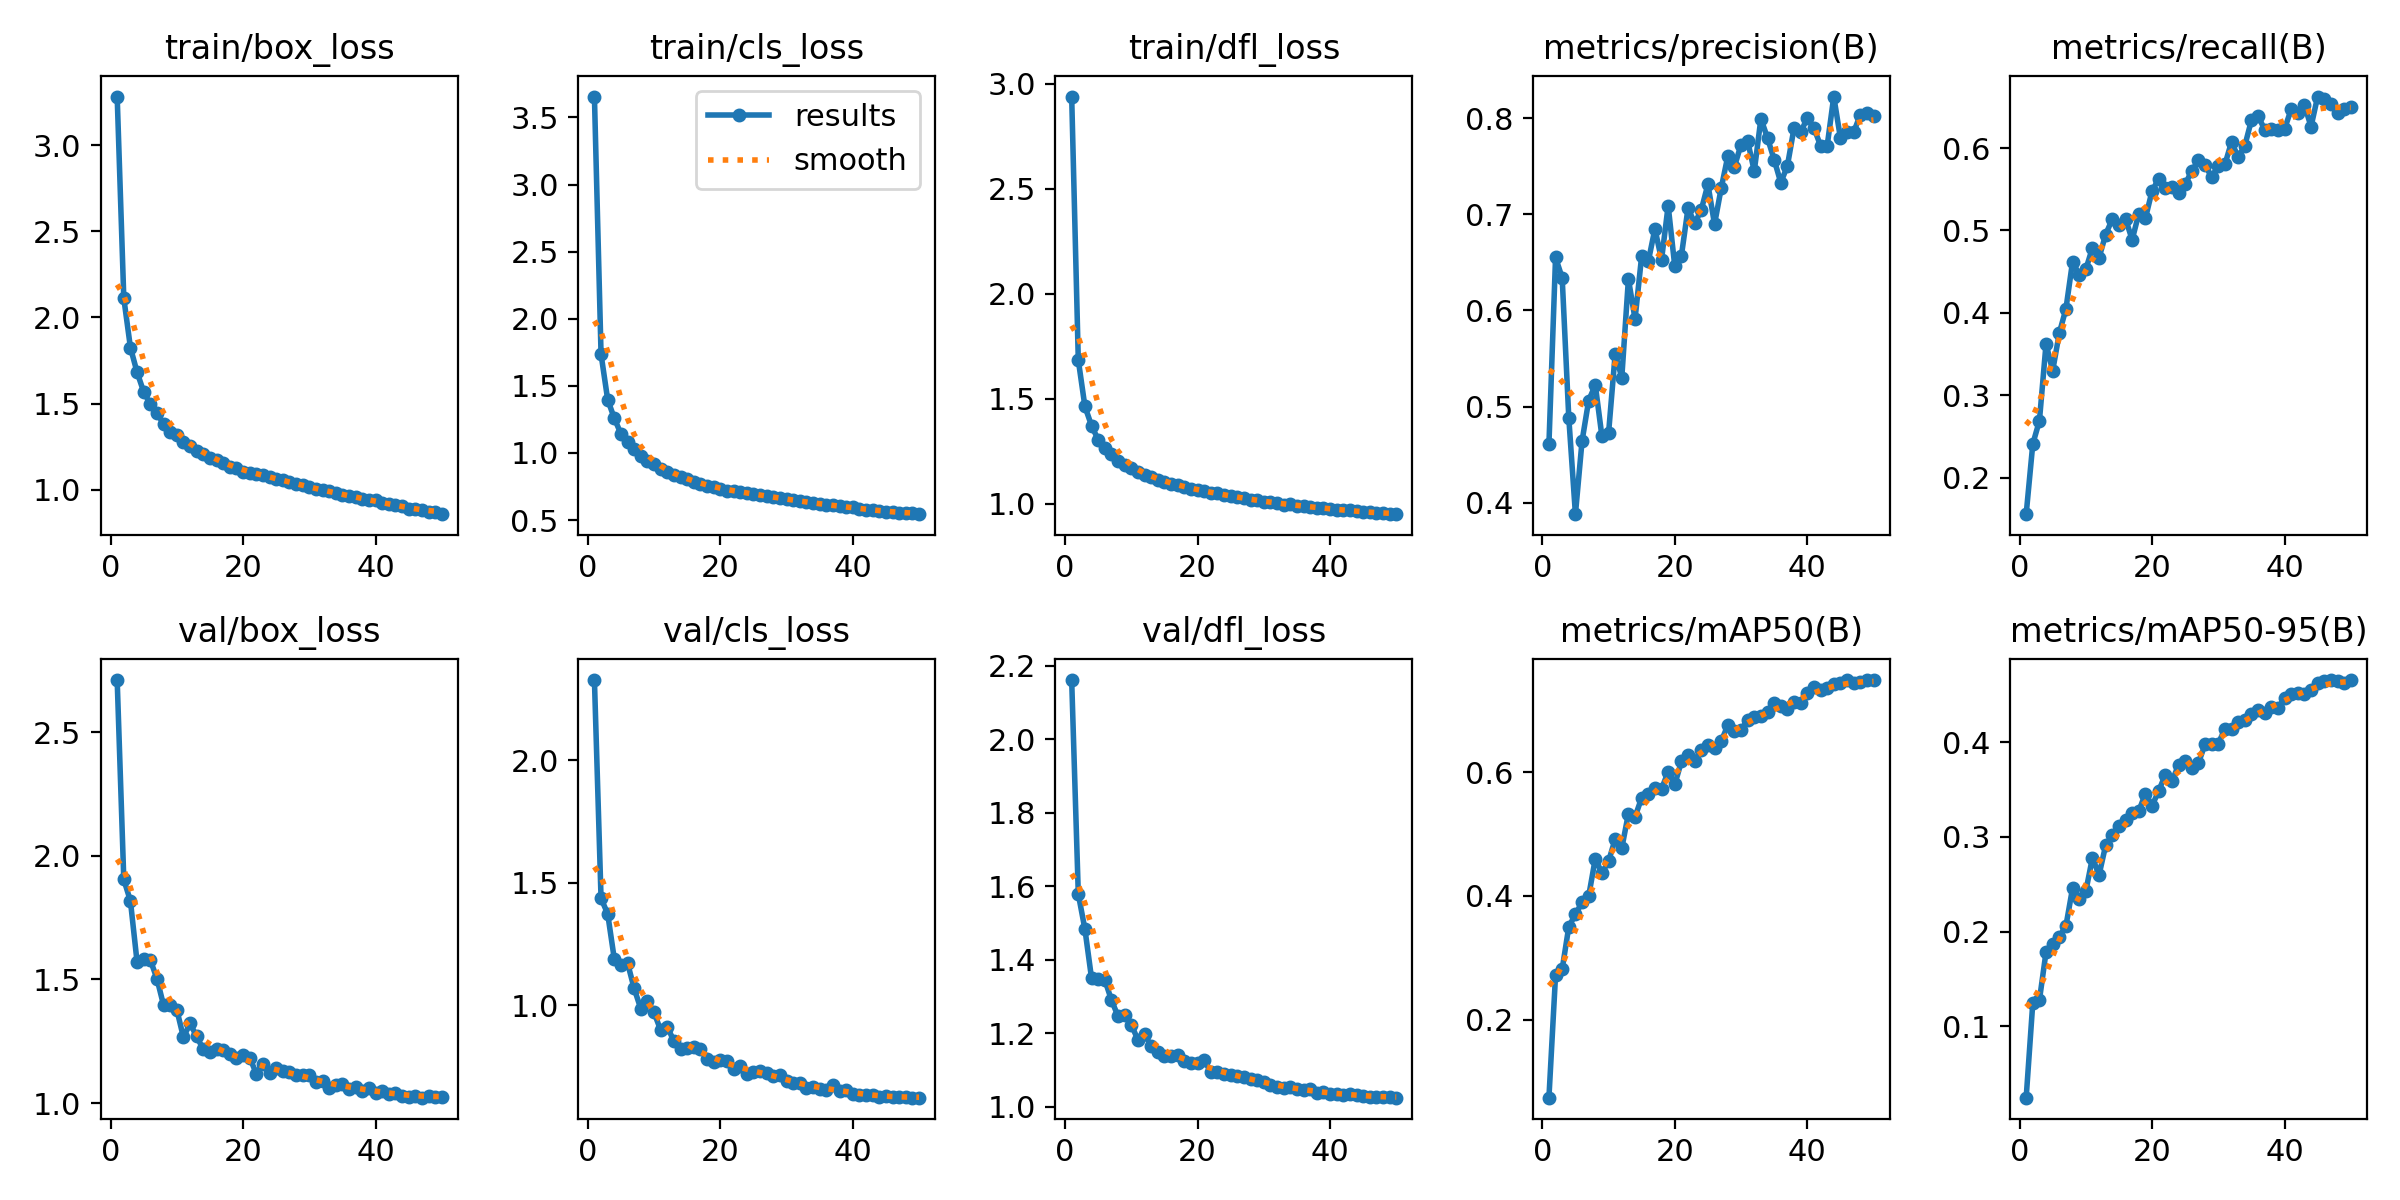

In [ ]:
# Hiển thị kết quả học (precision/recall/mAP curve)
display(DispImage(str(RUN_DIR/'results.png'), width=600))

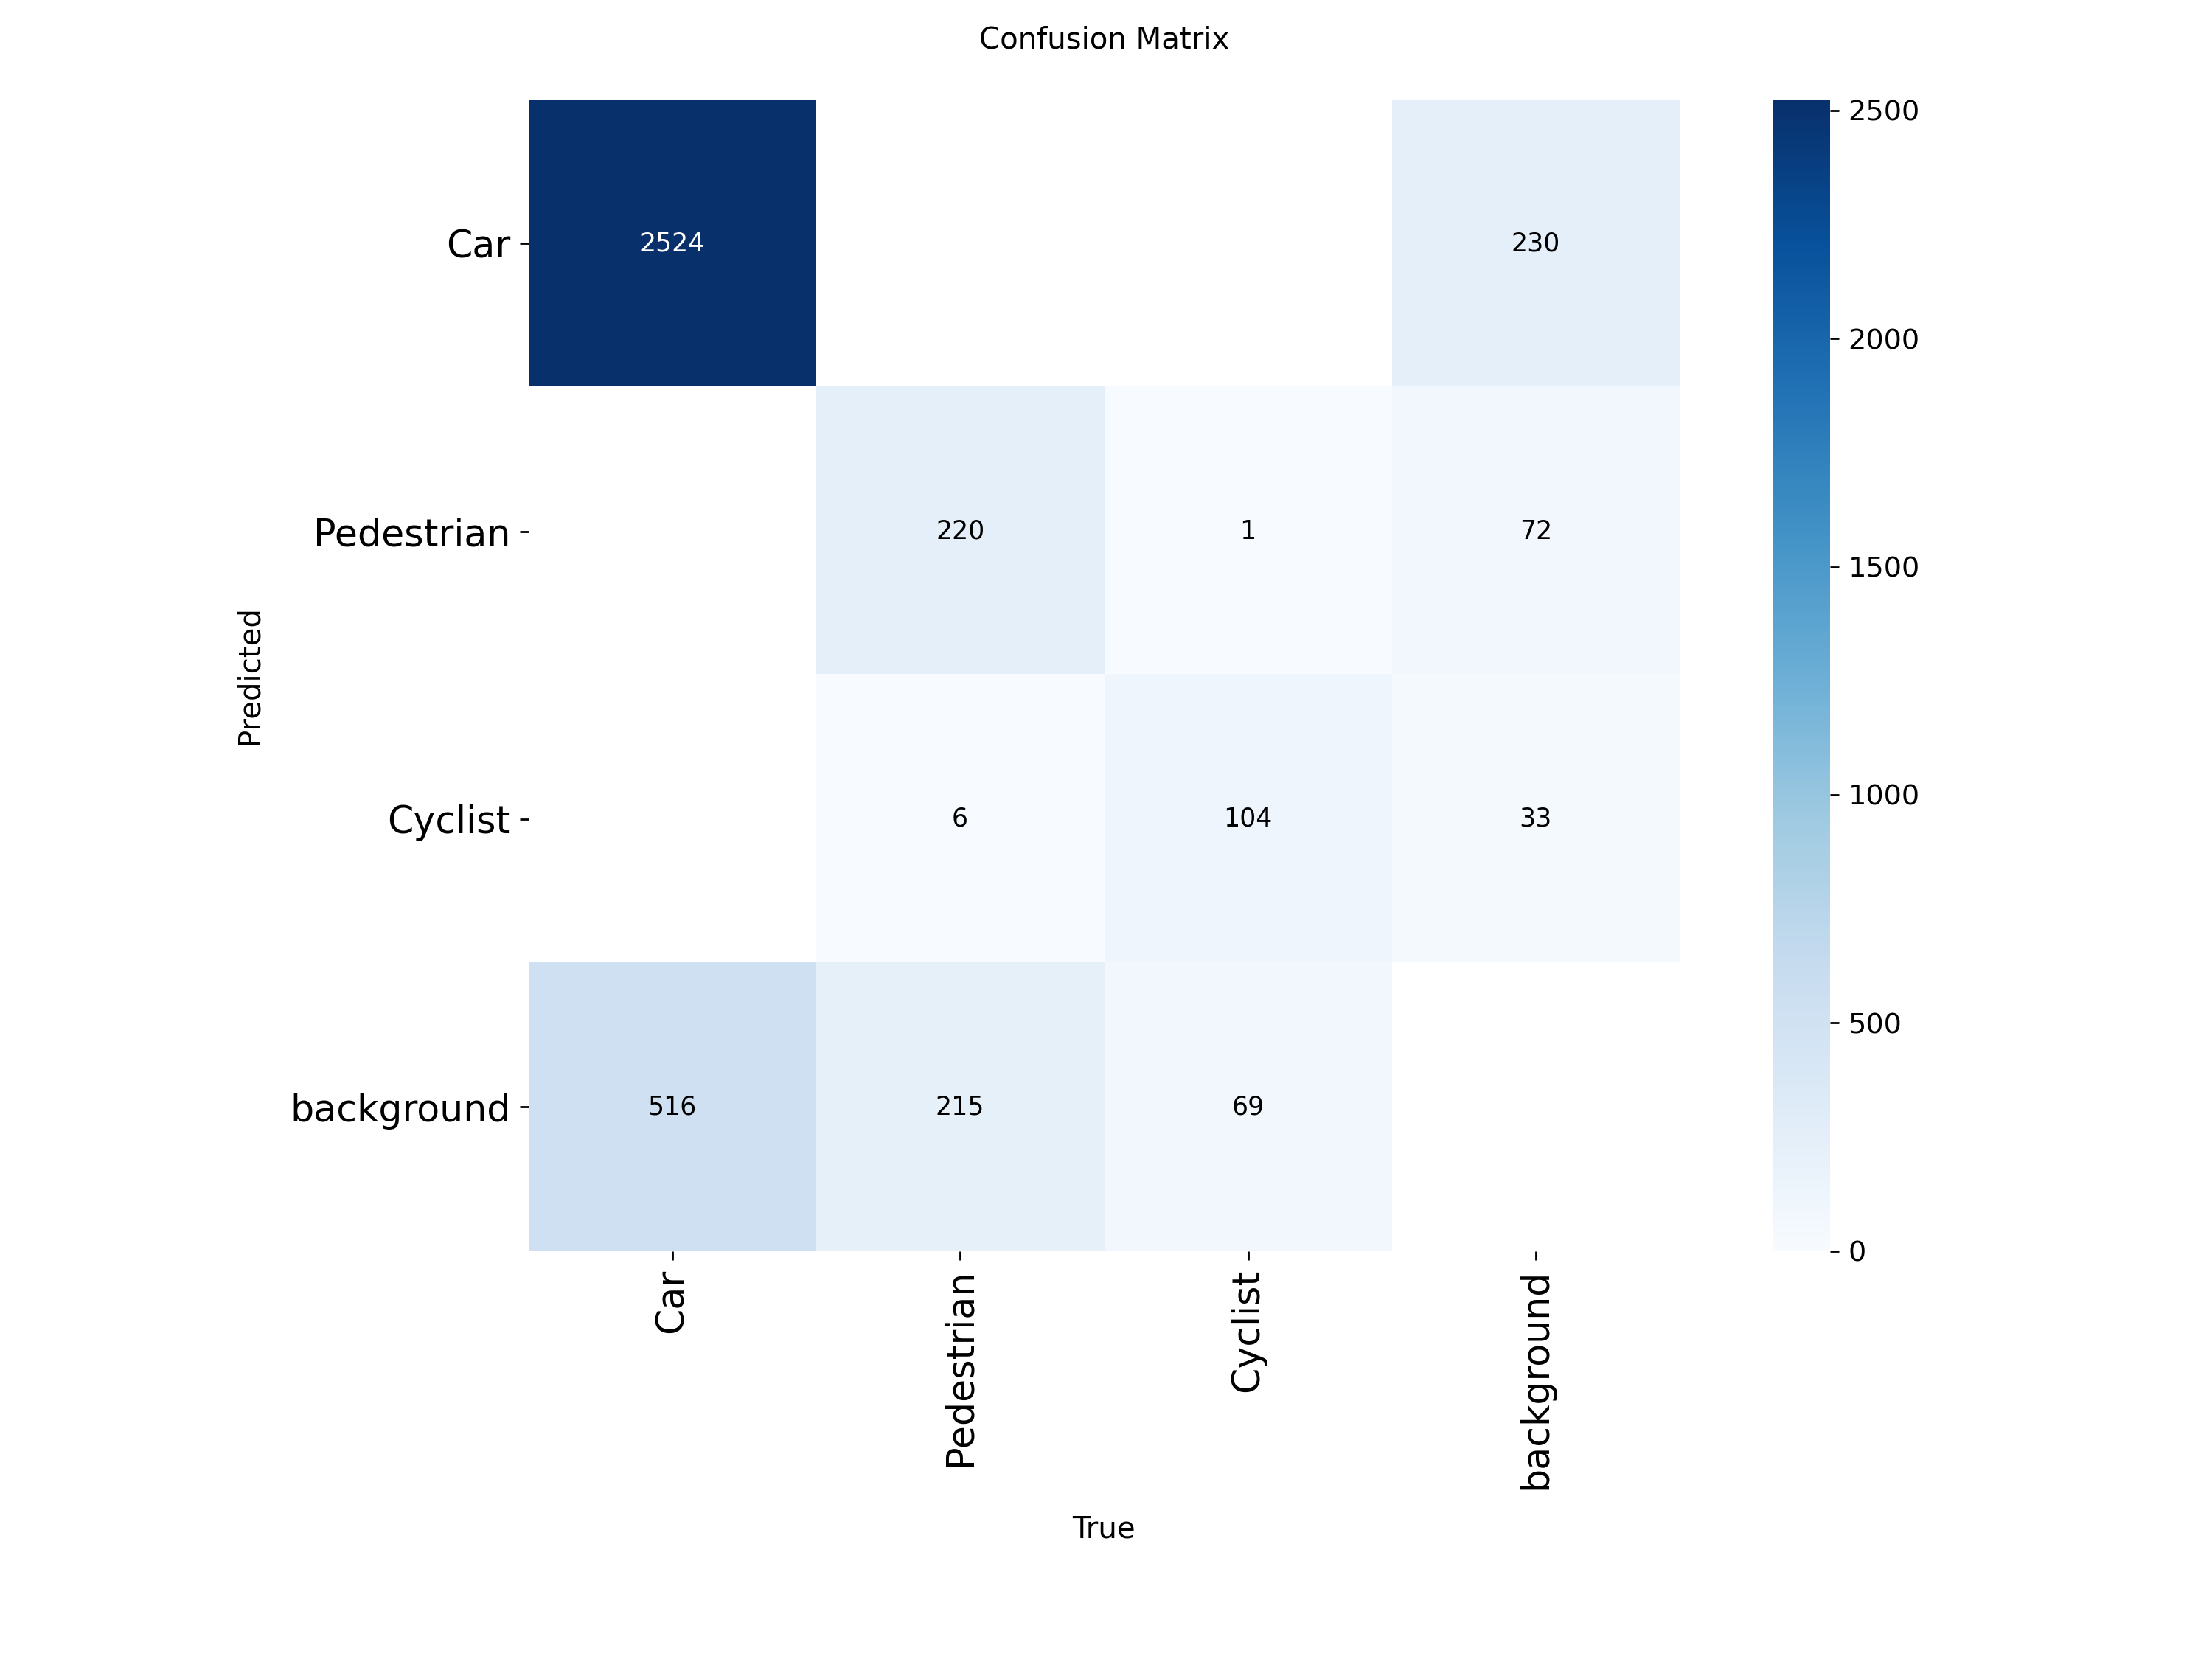

In [ ]:
# Hiển thị confusion matrix
display(DispImage(str(RUN_DIR/'confusion_matrix.png'), width=600))

## **đánh giá trên toàn bộ tập test**

In [ ]:
OUT_KITTI   = ROOT / 'kitti_preds_4chan_exp2'

In [ ]:
# Load best.pt
best_pt = ROOT/'runs'/'yolov8_4chan_exp2'/'weights'/'best.pt'
model   = YOLO(str(best_pt))

OUT_KITTI.mkdir(exist_ok=True)
cls_map = {0:'Car',1:'Pedestrian',2:'Cyclist'}

for img_path in sorted(RGBD_TEST.glob('*_rgbd.png')):
    stem = img_path.stem.replace('_rgbd','')

      # --- chuẩn bị im4 như trước ---
    rgba_uint16 = cv2.imread(str(img_path), cv2.IMREAD_UNCHANGED)
    rgba = rgba_uint16.astype(np.float32)
    bgr   = rgba[..., :3]
    depth = rgba[..., 3] / 65535.0 * 255.0
    depth = depth[..., None]
    im4   = np.dstack((bgr, depth))

    # --- chạy predict với numpy array ---
    res = model.predict(source=im4, imgsz=640, device=0, verbose=False)[0]

    # --- trích kết quả và ghi thành file KITTI ---
    boxes   = res.boxes.xyxy.cpu().numpy()
    classes = res.boxes.cls.cpu().numpy().astype(int)
    confs   = res.boxes.conf.cpu().numpy()

    with open(OUT_KITTI/f'{stem}.txt','w') as f:
        for (x1,y1,x2,y2), c, p in zip(boxes, classes, confs):
            f.write(
                f"{cls_map[c]} 0 0 0 "
                f"{x1:.2f} {y1:.2f} {x2:.2f} {y2:.2f} "
                "0 0 0 0 0 0 0 "
                f"{p:.4f}\n"
            )
print(f"[✓] Đã xuất {len(list(OUT_KITTI.glob('*.txt')))} files tại {OUT_KITTI}")

[✓] Đã xuất 7518 files tại /content/drive/MyDrive/Khóa Luận/Data_Object/Code/Early_Fusion_RGBD_Yolov8/4chan/kitti_preds_4chan_exp2


In [ ]:
# Nén cả thư mục dạng zip
shutil.make_archive('kitti_predictions_4chan_exp2', 'zip', root_dir=str(OUT_KITTI))
print("Tạo file kitti_predictions_4chan_exp2.zip thành công!")

Tạo file kitti_predictions_4chan_exp2.zip thành công!


# **Thực nghiệm 2 - chạy với RGBD + inpaint**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install ultralytics -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 60.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 104.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 101.7 MB/s eta 0:00:00


In [ ]:
# 1) Tải pretrained weights về /content
!wget -q -O /content/yolov8n.pt \
     https://github.com/ultralytics/assets/releases/download/v0.0.0/yolov8n.pt

In [ ]:
import torch, cv2, numpy as np
import os, shutil
from pathlib import Path
from tqdm.auto import tqdm
from ultralytics import YOLO
from sklearn.model_selection import train_test_split
from ultralytics.data.dataset import YOLODataset
from IPython.display import Image as DispImage, display

## **Các đường dẫn file**

In [ ]:
# ROOT trỏ vào folder chứa code 4chan của bạn
ROOT        = Path('/content/drive/MyDrive/Khóa Luận/Data_Object/Code/Early_Fusion_RGBD_Yolov8/4chan')

# Ảnh RGB-D và nhãn gốc
RGBD_TRAIN  = ROOT / 'rgbd_images_training'
RGBD_TEST   = ROOT / 'rgbd_images_testing'
LABELS_YOLO = Path('/content/drive/MyDrive/Khóa Luận/Data_Object/labels_yolo/')

# Config model & data
CFG     = ROOT / 'yolo_4chan-det.yaml'
COCO_PT = '/content/yolov8n.pt'
DATA_YAML   = ROOT / 'rgbd_data.yaml'

# Nơi lưu kết quả predict KITTI-format
OUT_KITTI   = ROOT / 'kitti_preds_4chan_exp1'


In [ ]:
import zipfile

ZIP_PATH = Path('/content/drive/MyDrive/Khóa Luận/Data_Object/Code/Early_Fusion_RGBD_Yolov8/4chan/train_valid_inpaint.zip')

# Thư mục giải nén
EXTRACT_DIR = Path('/content')

# Giải nén
with zipfile.ZipFile(ZIP_PATH, 'r') as zf:
    zf.extractall(EXTRACT_DIR)

print(f"[✓] Đã giải nén {ZIP_PATH.name} vào {EXTRACT_DIR}")

[✓] Đã giải nén train_valid_inpaint.zip vào /content


## **Tạo file dataset YAML**

In [ ]:
DATA_YAML = Path('/content/rgbd_data.yaml')
yaml_content = f"""
train: /content/train/images
val:   /content/valid/images

nc: 3
names: ['Car','Pedestrian','Cyclist']
channels: 4
""".strip()
DATA_YAML.write_text(yaml_content)
print(DATA_YAML.read_text())

## **Custom Dataset (4-kênh)**

In [ ]:
def load_image_rgba(self, i):
    # 1) Đọc file 4-ch uint16
    path = self.im_files[i]
    img = cv2.imread(str(path), cv2.IMREAD_UNCHANGED)
    if img is None:
        raise FileNotFoundError(f"Cannot read {path}")
    # 2) Cast về float32 và normalize
    img = img.astype(np.float32)
    depth = img[...,3].astype(np.float32) / 65535.0 * 255.0
    depth = depth[..., None]                # shape (H,W,1)
    im4 = np.dstack((img[..., :3], depth))

    # 3) Chuẩn bị hw0, hw (bằng nhau tạm thời)
    h0, w0 = im4.shape[:2]
    hw     = (h0, w0)

    return im4, (h0, w0), hw

# Áp monkey-patch
YOLODataset.load_image = load_image_rgba

In [ ]:
# Cell – Build model từ config 4-kênh
# (chưa load pretrained)
model = YOLO(str(CFG))  # architecture 4-ch, random init


In [ ]:
# Cell – Remap conv đầu tiên (3→4 kênh)
from ultralytics.nn.modules import Conv
conv1 = next(m for m in model.model.model if isinstance(m, Conv))

w = conv1.conv.weight.data    # shape (out_c, 3, k, k)
# Tạo weight mới shape (out_c, 4, k, k)
new_w = torch.zeros((w.size(0), 4, w.size(2), w.size(3)), device=w.device)
new_w[:, :3] = w                      # copy 3 kênh RGB
new_w[:,  3] = w.mean(dim=1)          # init kênh depth = mean(RGB)
conv1.conv = torch.nn.Conv2d(        # rebuild Conv2d layer
    in_channels=4,
    out_channels=conv1.conv.out_channels,
    kernel_size=conv1.conv.kernel_size,
    stride=conv1.conv.stride,
    padding=conv1.conv.padding,
    bias=conv1.conv.bias is not None
)
conv1.conv.weight = torch.nn.Parameter(new_w)
print("✅ Remap conv1 sang 4 kênh xong!")


chỉ nạp những tham số cùng shape với model

In [ ]:
import torch
from collections import OrderedDict

# 2) Load checkpoint
ckpt = torch.load(COCO_PT, map_location='cpu', weights_only=False)
sd   = ckpt['model'].float().state_dict() if 'model' in ckpt else ckpt

# 3) Pop toàn bộ conv1 (cả weight + bn params) nếu muốn remap riêng
for key in list(sd.keys()):
    if key.startswith('model.model.0'):
        sd.pop(key)

# 4) Lấy state_dict hiện tại của model
model_sd = model.model.state_dict()

# 5) Giữ lại chỉ những weights có cùng tên và cùng shape
filtered_sd = OrderedDict()
for k, v in sd.items():
    if k in model_sd and model_sd[k].shape == v.shape:
        filtered_sd[k] = v
    else:
        # bạn có thể in ra để debug
        # print("skip", k, v.shape, "vs", model_sd.get(k, None))
        pass

print(f"📦 Nạp {len(filtered_sd)}/{len(model_sd)} tham số từ COCO checkpoint")
model.model.load_state_dict(filtered_sd, strict=False)

In [ ]:
train_results = model.train(
    data    = str(DATA_YAML),
    epochs  = 50,
    patience = 5,
    device  = 0,
    mosaic  = 0.0,
    project = str(ROOT/'runs'),
    name    = 'yolov8_4chan_inpaint'
)

Ultralytics 8.3.163 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/rgbd_data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/content/drive/MyDrive/Khóa Luận/Data_Object/Code/Early_Fusion_RGBD_Yolov8/4chan/yolo_4chan-det.yaml, momentum=0.937, mosaic=0.0, multi_scale=False, name=yolov8_4chan_inpaint, nbs=64, nms=False, opset=None, op

100%|██████████| 755k/755k [00:00<00:00, 17.3MB/s]


                   from  n    params  module                                       arguments                     
  0                  -1  1       608  ultralytics.nn.modules.conv.Conv             [4, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

YOLO_4chan-det summary: 129 layers, 3,011,577 parameters, 3,011,561 gradients, 8.2 GFLOPs

Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 69.7MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3102.1±2095.8 MB/s, size: 1323.1 KB)


train: Scanning /content/train/labels... 6732 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6732/6732 [00:47<00:00, 142.11it/s]


train: New cache created: /content/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3757.8±2346.3 MB/s, size: 1406.1 KB)


val: Scanning /content/valid/labels... 749 images, 0 backgrounds, 0 corrupt: 100%|██████████| 749/749 [00:05<00:00, 147.91it/s]

val: New cache created: /content/valid/labels.cache


Plotting labels to /content/drive/MyDrive/Khóa Luận/Data_Object/Code/Early_Fusion_RGBD_Yolov8/4chan/runs/yolov8_4chan_inpaint/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/drive/MyDrive/Khóa Luận/Data_Object/Code/Early_Fusion_RGBD_Yolov8/4chan/runs/yolov8_4chan_inpaint
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.43G      3.128      3.458      2.825         49        640: 100%|██████████| 421/421 [01:06<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.63it/s]

                   all        749       3655      0.596      0.201      0.162     0.0631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.45G      1.955      1.628      1.598         46        640: 100%|██████████| 421/421 [01:05<00:00,  6.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.77it/s]


                   all        749       3655      0.294      0.294      0.297      0.133

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.46G      1.723      1.318      1.427         47        640: 100%|██████████| 421/421 [01:05<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  4.96it/s]

                   all        749       3655      0.491      0.304      0.328      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.48G      1.587      1.186      1.339         57        640: 100%|██████████| 421/421 [01:04<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.70it/s]

                   all        749       3655      0.457      0.406      0.404      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50       2.5G      1.489      1.079      1.281         64        640: 100%|██████████| 421/421 [01:05<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  4.96it/s]

                   all        749       3655      0.557      0.318      0.387      0.186



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.52G      1.424      1.012       1.24         57        640: 100%|██████████| 421/421 [01:05<00:00,  6.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.10it/s]

                   all        749       3655      0.489      0.408      0.431      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.53G      1.373     0.9666      1.213         50        640: 100%|██████████| 421/421 [01:05<00:00,  6.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.02it/s]


                   all        749       3655       0.56      0.451      0.474      0.265

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.55G      1.322     0.9226      1.183         46        640: 100%|██████████| 421/421 [01:05<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.71it/s]


                   all        749       3655      0.445      0.479      0.472      0.252

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.57G      1.294     0.8934      1.167         55        640: 100%|██████████| 421/421 [01:05<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.73it/s]

                   all        749       3655      0.515      0.482      0.496       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.58G      1.258     0.8645      1.149         47        640: 100%|██████████| 421/421 [01:05<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.17it/s]

                   all        749       3655      0.589      0.477      0.514      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50       2.6G       1.23     0.8453      1.139         65        640: 100%|██████████| 421/421 [01:05<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  4.82it/s]

                   all        749       3655      0.626      0.512      0.552      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.62G      1.214     0.8181      1.126         63        640: 100%|██████████| 421/421 [01:05<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.35it/s]

                   all        749       3655      0.565      0.484      0.511      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.63G      1.186     0.8053      1.115         56        640: 100%|██████████| 421/421 [01:05<00:00,  6.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.00it/s]

                   all        749       3655      0.595      0.523      0.566      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.65G      1.171     0.7833      1.104         47        640: 100%|██████████| 421/421 [01:05<00:00,  6.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  4.91it/s]


                   all        749       3655      0.567      0.535      0.559      0.315

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.67G      1.157     0.7659      1.097         52        640: 100%|██████████| 421/421 [01:04<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.77it/s]

                   all        749       3655      0.631       0.56      0.592      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.69G      1.141     0.7557       1.09         45        640: 100%|██████████| 421/421 [01:04<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.40it/s]

                   all        749       3655       0.66       0.57      0.617      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.71G      1.123     0.7372       1.08         53        640: 100%|██████████| 421/421 [01:05<00:00,  6.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.03it/s]

                   all        749       3655      0.722      0.563      0.636      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.72G      1.105     0.7269      1.074         40        640: 100%|██████████| 421/421 [01:05<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  4.85it/s]

                   all        749       3655      0.684      0.554      0.609      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.74G      1.086     0.7124      1.066         51        640: 100%|██████████| 421/421 [01:05<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  4.98it/s]

                   all        749       3655      0.717      0.587      0.652       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.76G      1.085      0.704      1.063         67        640: 100%|██████████| 421/421 [01:05<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  4.99it/s]

                   all        749       3655      0.706      0.594      0.643      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.77G      1.065     0.6833      1.052         59        640: 100%|██████████| 421/421 [01:04<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.74it/s]

                   all        749       3655       0.71      0.551      0.637      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.79G      1.056     0.6821      1.051         66        640: 100%|██████████| 421/421 [01:05<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  4.83it/s]

                   all        749       3655      0.725      0.563      0.635      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.81G      1.046     0.6753      1.046         68        640: 100%|██████████| 421/421 [01:05<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.13it/s]

                   all        749       3655      0.722      0.597      0.662       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.82G      1.039     0.6631      1.038         56        640: 100%|██████████| 421/421 [01:05<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  4.90it/s]

                   all        749       3655      0.698      0.593      0.657       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.84G      1.021     0.6515      1.036         52        640: 100%|██████████| 421/421 [01:05<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.16it/s]

                   all        749       3655      0.794      0.594       0.69      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.86G      1.014     0.6475      1.027         69        640: 100%|██████████| 421/421 [01:04<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.48it/s]

                   all        749       3655      0.759      0.607      0.681      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.88G      1.008      0.639      1.026         51        640: 100%|██████████| 421/421 [01:05<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.01it/s]

                   all        749       3655      0.766      0.612      0.694      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.89G     0.9944     0.6325      1.021         44        640: 100%|██████████| 421/421 [01:05<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.13it/s]

                   all        749       3655      0.805      0.609      0.707      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.91G     0.9891     0.6194      1.017         42        640: 100%|██████████| 421/421 [01:04<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.61it/s]

                   all        749       3655      0.771      0.623      0.722      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.93G     0.9774     0.6139      1.014         57        640: 100%|██████████| 421/421 [01:05<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.02it/s]

                   all        749       3655      0.804      0.614      0.716      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.94G     0.9724     0.6071      1.008         51        640: 100%|██████████| 421/421 [01:04<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.76it/s]

                   all        749       3655      0.814       0.63      0.732      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.96G     0.9579     0.5986      1.003         63        640: 100%|██████████| 421/421 [01:05<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  4.99it/s]

                   all        749       3655      0.805      0.625      0.732      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.98G     0.9527      0.591      0.998         60        640: 100%|██████████| 421/421 [01:04<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.70it/s]

                   all        749       3655       0.78      0.662      0.742      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.99G     0.9492     0.5922     0.9981         33        640: 100%|██████████| 421/421 [01:05<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.78it/s]

                   all        749       3655      0.804      0.657      0.748      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      3.01G     0.9372     0.5801     0.9939         47        640: 100%|██████████| 421/421 [01:04<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  4.88it/s]

                   all        749       3655      0.773      0.683      0.754      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      3.03G      0.926     0.5712     0.9916         39        640: 100%|██████████| 421/421 [01:05<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.24it/s]

                   all        749       3655      0.813      0.668      0.763      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      3.04G     0.9164     0.5656      0.985         41        640: 100%|██████████| 421/421 [01:05<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.17it/s]

                   all        749       3655       0.79      0.673      0.755      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      3.06G     0.9118     0.5607     0.9855         47        640: 100%|██████████| 421/421 [01:06<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  4.98it/s]

                   all        749       3655      0.755      0.684      0.748      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      3.08G     0.9042      0.555     0.9809         71        640: 100%|██████████| 421/421 [01:05<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.66it/s]

                   all        749       3655       0.87      0.661      0.774      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50       3.1G     0.8926     0.5489     0.9783         48        640: 100%|██████████| 421/421 [01:04<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.75it/s]

                   all        749       3655      0.849      0.658       0.77      0.473


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      3.11G      0.883     0.5436     0.9729         76        640: 100%|██████████| 421/421 [01:03<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.12it/s]

                   all        749       3655      0.823       0.68      0.769      0.467
EarlyStopping: Training stopped early as no improvement observed in last 5 epochs. Best results observed at epoch 36, best model saved as best.pt.
To update EarlyStopping(patience=5) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



41 epochs completed in 0.806 hours.
Optimizer stripped from /content/drive/MyDrive/Khóa Luận/Data_Object/Code/Early_Fusion_RGBD_Yolov8/4chan/runs/yolov8_4chan_inpaint/weights/last.pt, 6.2MB
Optimizer stripped from /content/drive/MyDrive/Khóa Luận/Data_Object/Code/Early_Fusion_RGBD_Yolov8/4chan/runs/yolov8_4chan_inpaint/weights/best.pt, 6.2MB

Validating /content/drive/MyDrive/Khóa Luận/Data_Object/Code/Early_Fusion_RGBD_Yolov8/4chan/runs/yolov8_4chan_inpaint/weights/best.pt...
Ultralytics 8.3.163 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO_4chan-det summary (fused): 72 layers, 3,006,377 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  4.92it/s]


                   all        749       3655      0.813      0.669      0.763      0.479
                   Car        678       3040      0.899      0.838      0.924      0.679
            Pedestrian        179        441      0.668      0.587      0.649      0.343
               Cyclist        124        174      0.871       0.58      0.717      0.415
Speed: 0.2ms preprocess, 0.4ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to /content/drive/MyDrive/Khóa Luận/Data_Object/Code/Early_Fusion_RGBD_Yolov8/4chan/runs/yolov8_4chan_inpaint


## **Eval**

In [ ]:
# Đường dẫn tới folder chứa các file đồ thị của experiment
RUN_DIR = ROOT / 'runs' / 'yolov8_4chan_inpaint'

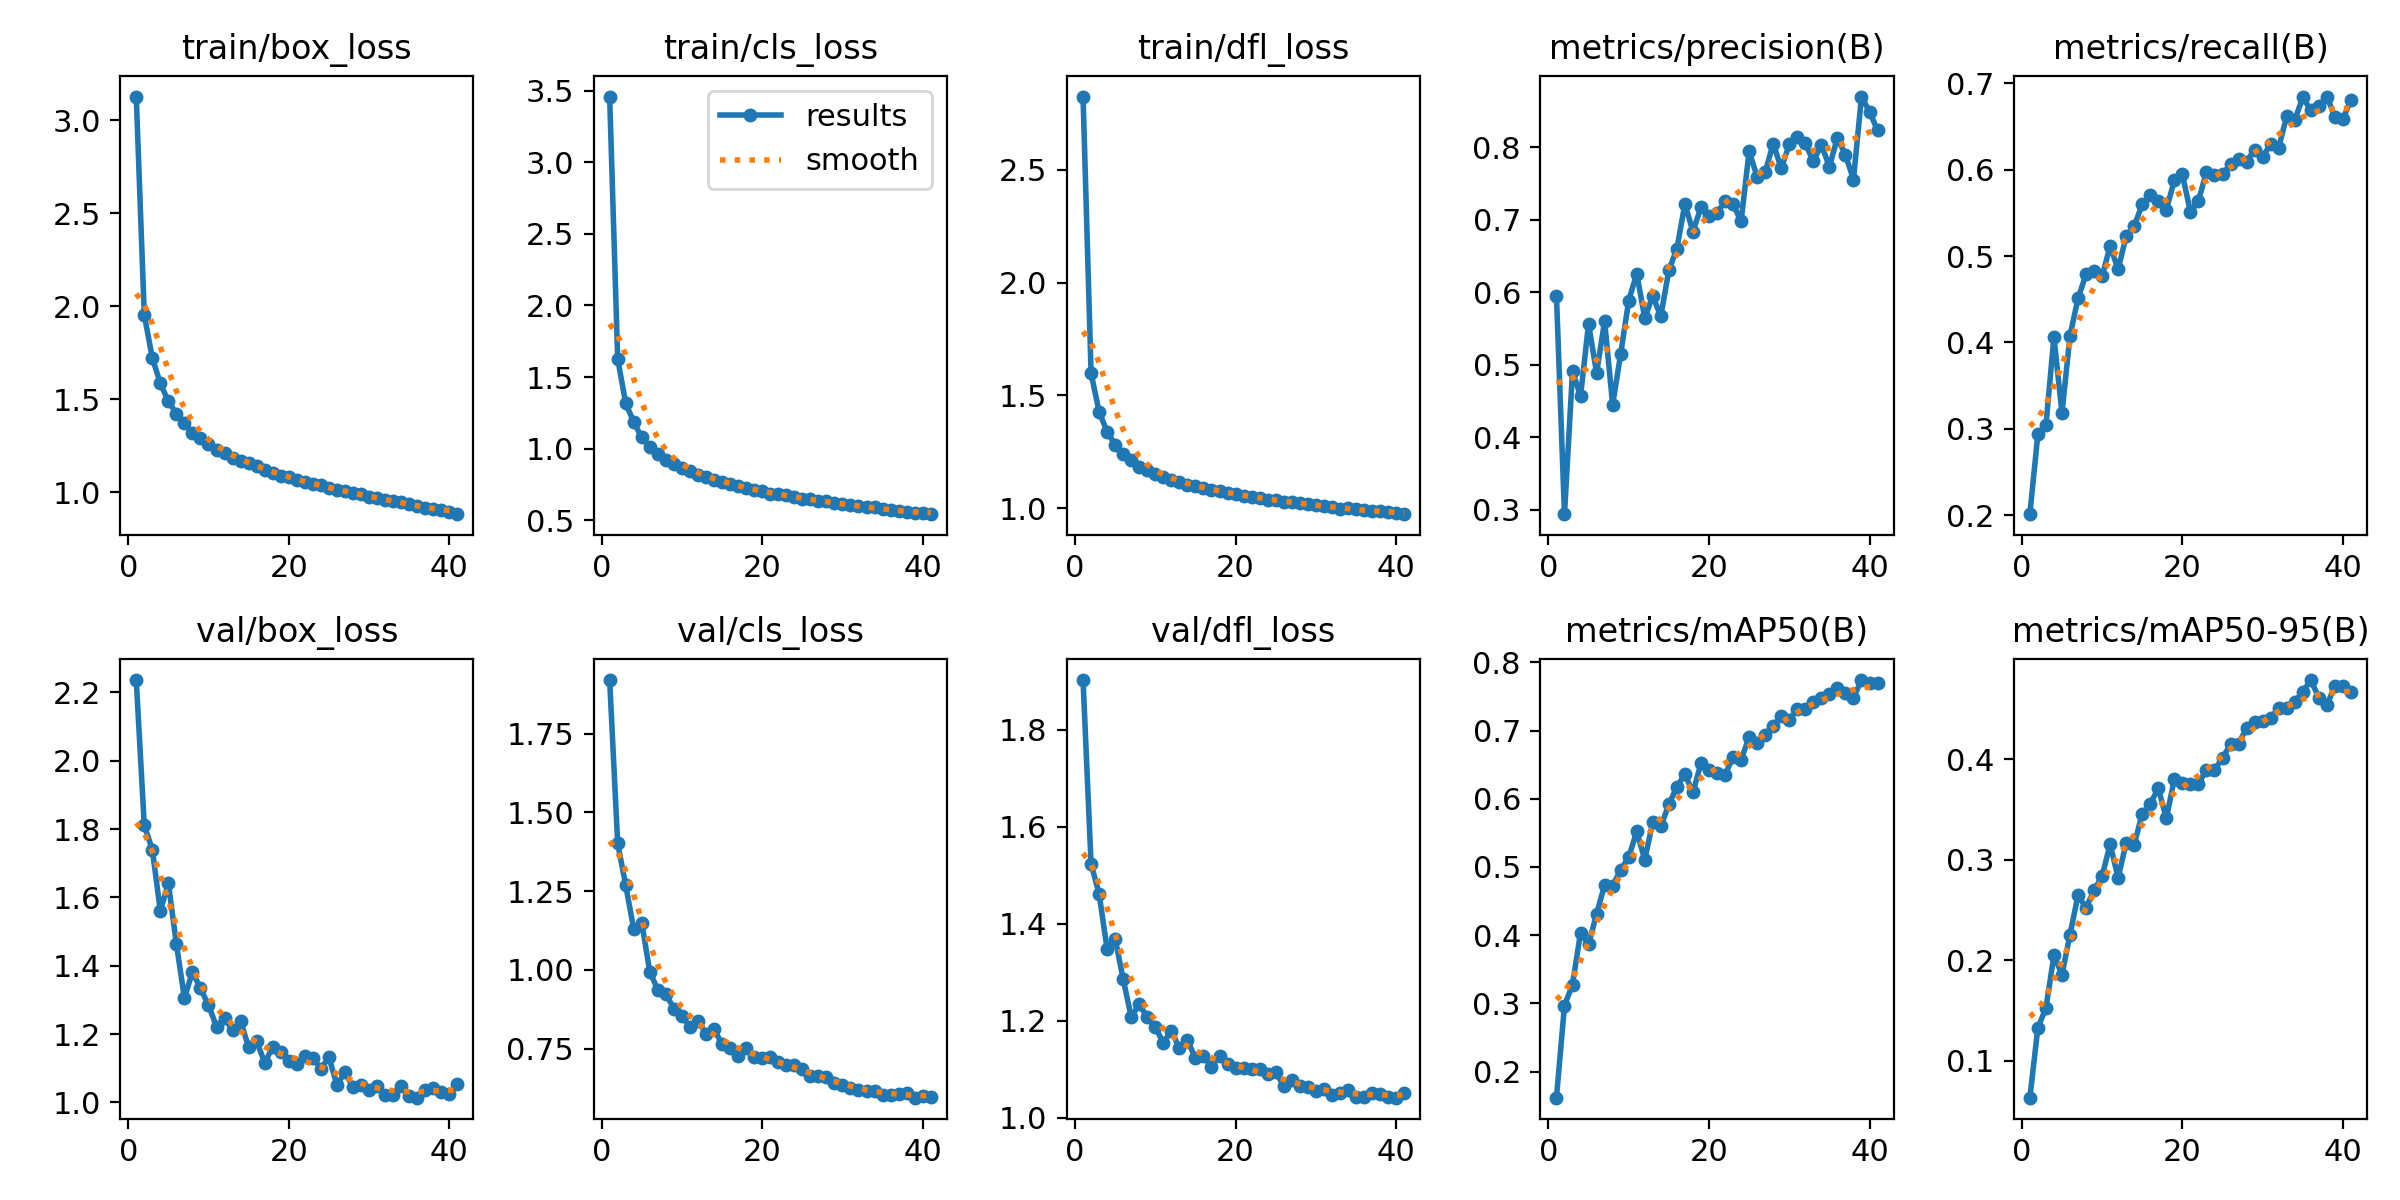

In [ ]:
# Hiển thị kết quả học (precision/recall/mAP curve)
display(DispImage(str(RUN_DIR/'results.png'), width=600))

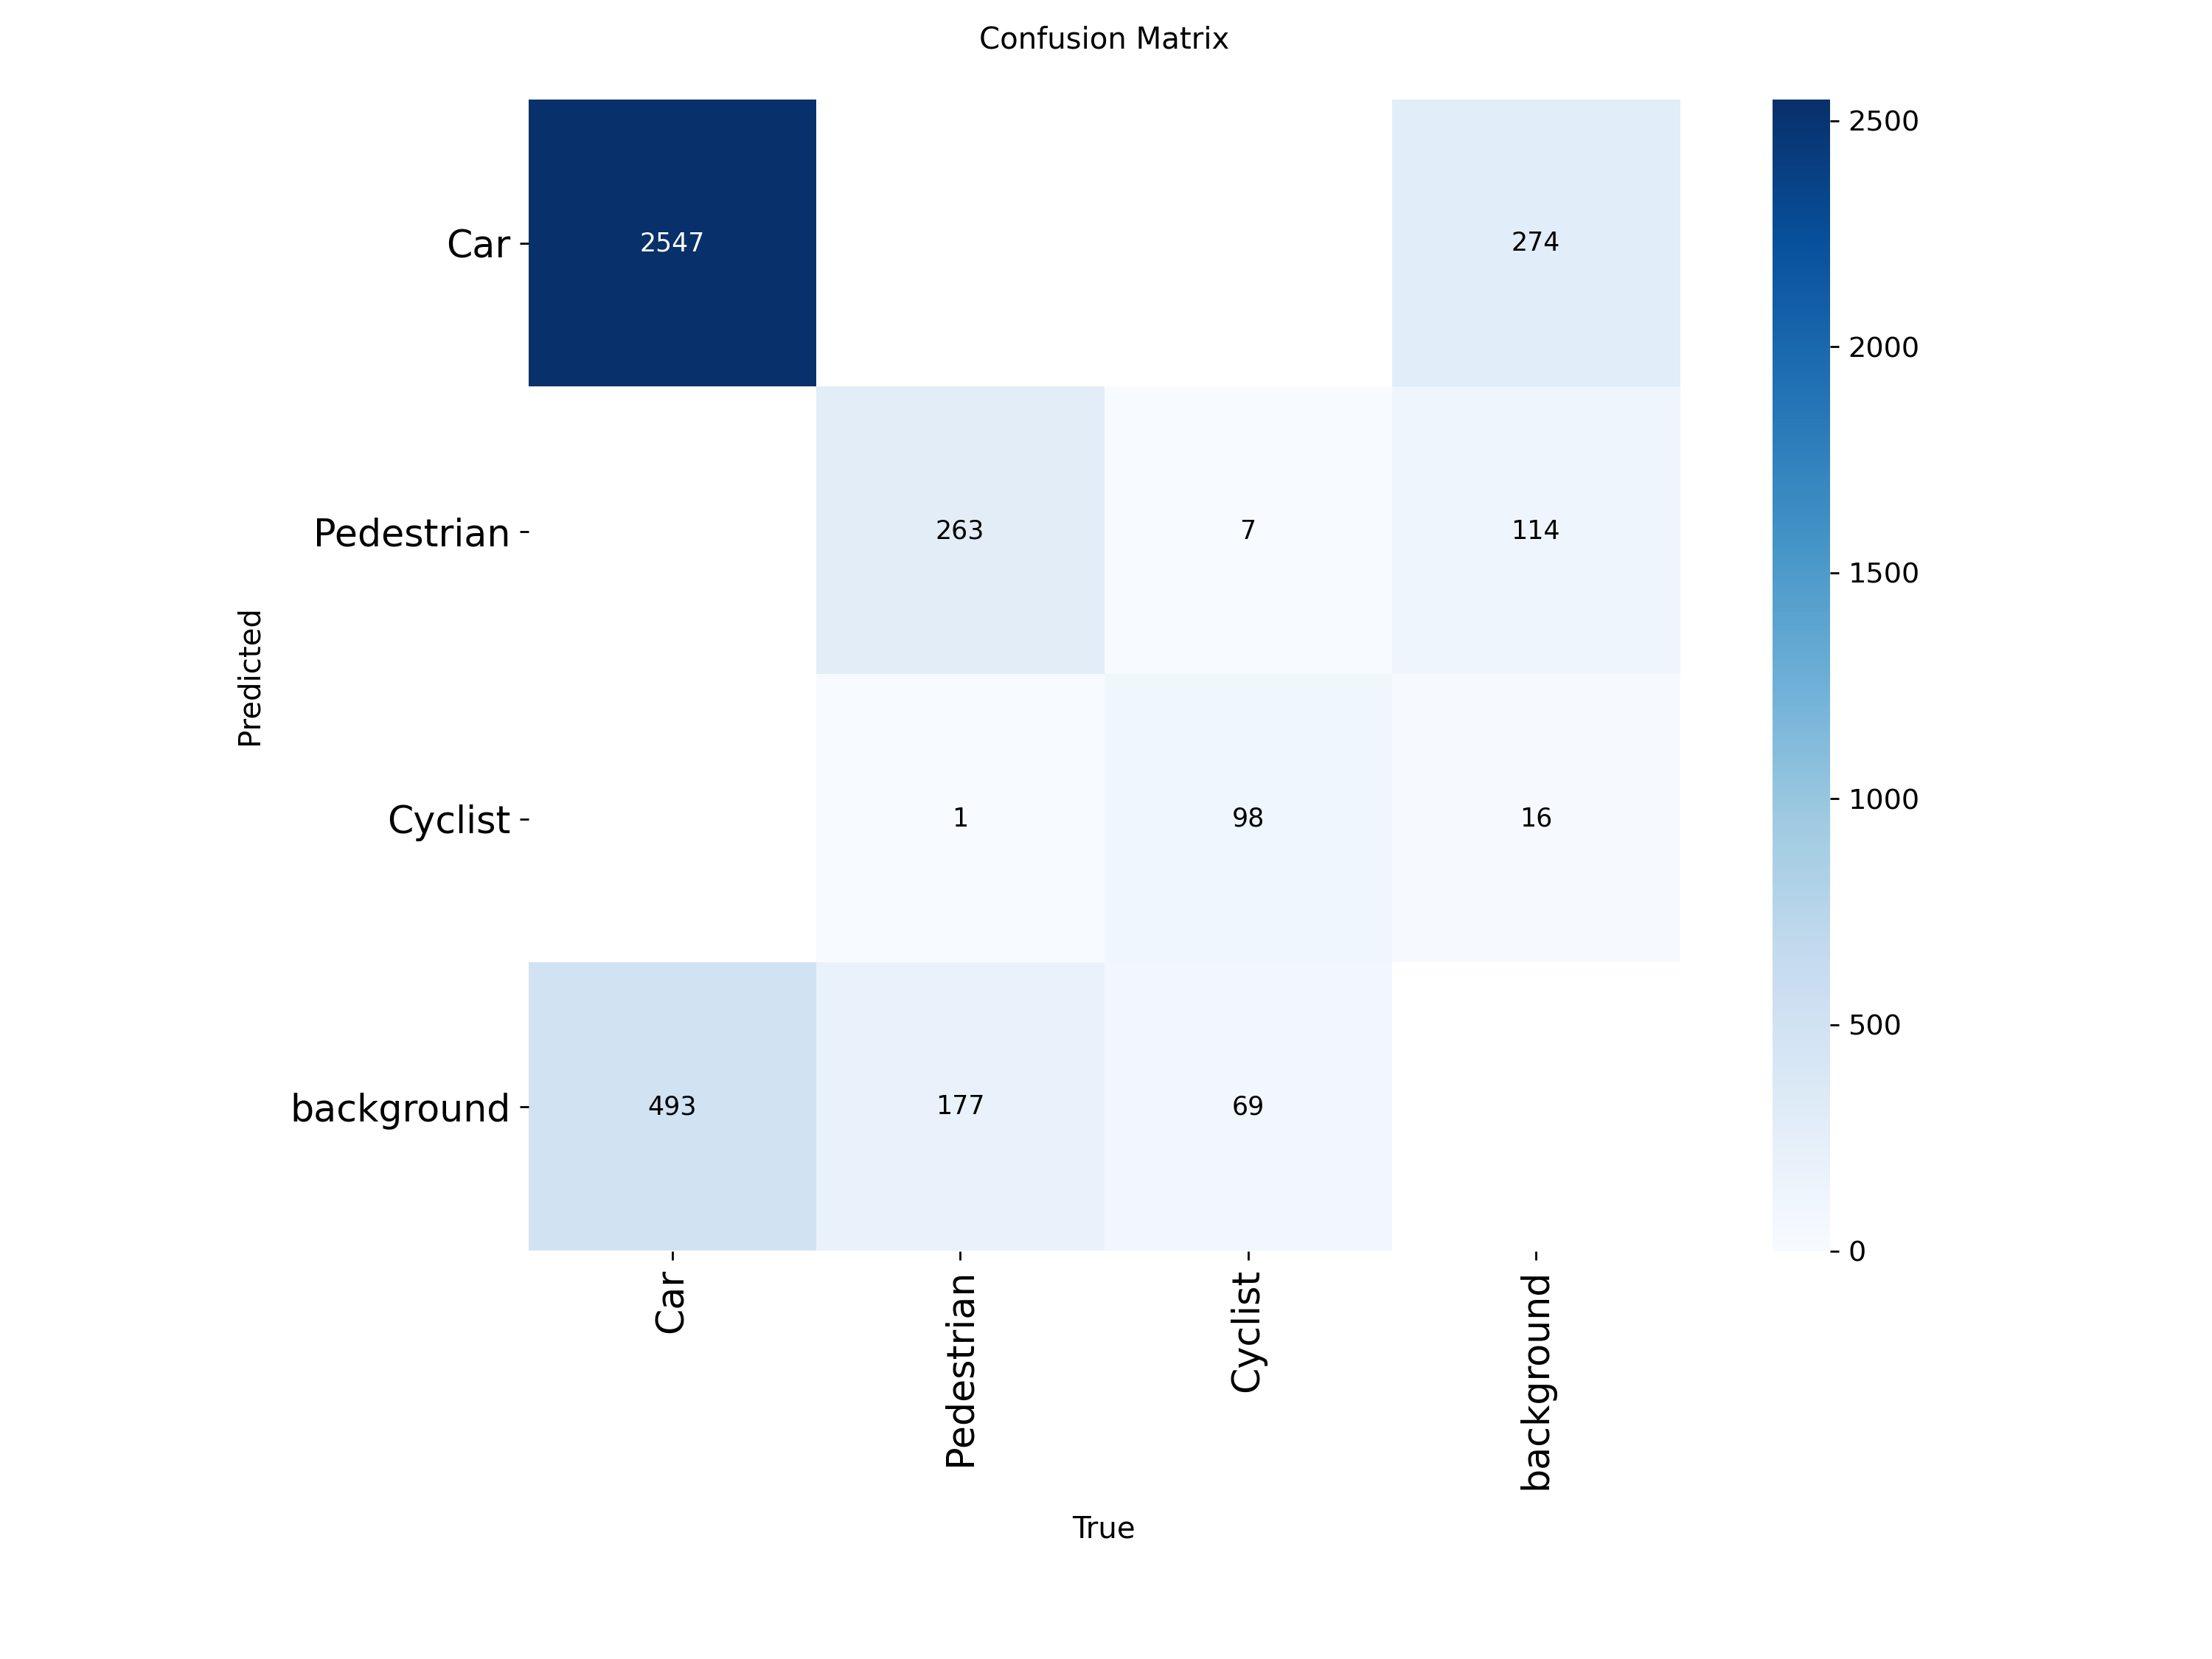

In [ ]:
# Hiển thị confusion matrix
display(DispImage(str(RUN_DIR/'confusion_matrix.png'), width=600))

# **Thực nghiệm 3 - RGBD + inpaint với 50 epoch**

thực nghiệm 3 + non early stop

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install ultralytics -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 129.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.7 MB/s eta 0:00:00


In [ ]:
# 1) Tải pretrained weights về /content
!wget -q -O /content/yolov8n.pt \
     https://github.com/ultralytics/assets/releases/download/v0.0.0/yolov8n.pt

In [ ]:
import torch, cv2, numpy as np
import os, shutil
from pathlib import Path
from tqdm.auto import tqdm
from ultralytics import YOLO
from sklearn.model_selection import train_test_split
from ultralytics.data.dataset import YOLODataset
from IPython.display import Image as DispImage, display

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## **Các đường dẫn file**

In [ ]:
# ROOT trỏ vào folder chứa code 4chan của bạn
ROOT        = Path('/content/drive/MyDrive/Khóa Luận/Data_Object/Code/Early_Fusion_RGBD_Yolov8/4chan')

# Ảnh RGB-D và nhãn gốc
RGBD_TRAIN  = ROOT / 'rgbd_images_inpaint_training'
RGBD_TEST   = ROOT / 'rgbd_images_inpaint_testing'
LABELS_YOLO = Path('/content/drive/MyDrive/Khóa Luận/Data_Object/labels_yolo/')

# Config model & data
CFG     = ROOT / 'yolo_4chan-det.yaml'
COCO_PT = '/content/yolov8n.pt'
DATA_YAML   = ROOT / 'rgbd_data.yaml'


In [ ]:
import zipfile

ZIP_PATH = Path('/content/drive/MyDrive/Khóa Luận/Data_Object/Code/Early_Fusion_RGBD_Yolov8/4chan/train_valid_inpaint.zip')

# Thư mục giải nén
EXTRACT_DIR = Path('/content')

# Giải nén
with zipfile.ZipFile(ZIP_PATH, 'r') as zf:
    zf.extractall(EXTRACT_DIR)

print(f"[✓] Đã giải nén {ZIP_PATH.name} vào {EXTRACT_DIR}")

[✓] Đã giải nén train_valid_inpaint.zip vào /content


## **Tạo file dataset YAML**

In [ ]:
DATA_YAML = Path('/content/rgbd_data.yaml')
yaml_content = f"""
train: /content/train/images
val:   /content/valid/images

nc: 3
names: ['Car','Pedestrian','Cyclist']
channels: 4
""".strip()
DATA_YAML.write_text(yaml_content)
print(DATA_YAML.read_text())

train: /content/train/images
val:   /content/valid/images

nc: 3
names: ['Car','Pedestrian','Cyclist']
channels: 4


## **Custom Dataset (4-kênh)**

In [ ]:
def load_image_rgba(self, i):
    # 1) Đọc file 4-ch uint16
    path = self.im_files[i]
    img = cv2.imread(str(path), cv2.IMREAD_UNCHANGED)
    if img is None:
        raise FileNotFoundError(f"Cannot read {path}")
    # 2) Cast về float32 và normalize
    img = img.astype(np.float32)
    depth = img[...,3].astype(np.float32) / 65535.0 * 255.0
    depth = depth[..., None]                # shape (H,W,1)
    im4 = np.dstack((img[..., :3], depth))

    # 3) Chuẩn bị hw0, hw (bằng nhau tạm thời)
    h0, w0 = im4.shape[:2]
    hw     = (h0, w0)

    return im4, (h0, w0), hw

# Áp monkey-patch
YOLODataset.load_image = load_image_rgba

In [ ]:
# Cell – Build model từ config 4-kênh
# (chưa load pretrained)
model = YOLO(str(CFG))  # architecture 4-ch, random init


In [ ]:
# Cell – Remap conv đầu tiên (3→4 kênh)
from ultralytics.nn.modules import Conv
conv1 = next(m for m in model.model.model if isinstance(m, Conv))

w = conv1.conv.weight.data    # shape (out_c, 3, k, k)
# Tạo weight mới shape (out_c, 4, k, k)
new_w = torch.zeros((w.size(0), 4, w.size(2), w.size(3)), device=w.device)
new_w[:, :3] = w                      # copy 3 kênh RGB
new_w[:,  3] = w.mean(dim=1)          # init kênh depth = mean(RGB)
conv1.conv = torch.nn.Conv2d(        # rebuild Conv2d layer
    in_channels=4,
    out_channels=conv1.conv.out_channels,
    kernel_size=conv1.conv.kernel_size,
    stride=conv1.conv.stride,
    padding=conv1.conv.padding,
    bias=conv1.conv.bias is not None
)
conv1.conv.weight = torch.nn.Parameter(new_w)
print("✅ Remap conv1 sang 4 kênh xong!")


✅ Remap conv1 sang 4 kênh xong!


chỉ nạp những tham số cùng shape với model

In [ ]:
import torch
from collections import OrderedDict

# 2) Load checkpoint
ckpt = torch.load(COCO_PT, map_location='cpu', weights_only=False)
sd   = ckpt['model'].float().state_dict() if 'model' in ckpt else ckpt

# 3) Pop toàn bộ conv1 (cả weight + bn params) nếu muốn remap riêng
for key in list(sd.keys()):
    if key.startswith('model.model.0'):
        sd.pop(key)

# 4) Lấy state_dict hiện tại của model
model_sd = model.model.state_dict()

# 5) Giữ lại chỉ những weights có cùng tên và cùng shape
filtered_sd = OrderedDict()
for k, v in sd.items():
    if k in model_sd and model_sd[k].shape == v.shape:
        filtered_sd[k] = v
    else:
        # bạn có thể in ra để debug
        # print("skip", k, v.shape, "vs", model_sd.get(k, None))
        pass

print(f"📦 Nạp {len(filtered_sd)}/{len(model_sd)} tham số từ COCO checkpoint")
model.model.load_state_dict(filtered_sd, strict=False)

📦 Nạp 318/355 tham số từ COCO checkpoint


_IncompatibleKeys(missing_keys=['model.0.conv.weight', 'model.22.cv3.0.0.conv.weight', 'model.22.cv3.0.0.bn.weight', 'model.22.cv3.0.0.bn.bias', 'model.22.cv3.0.0.bn.running_mean', 'model.22.cv3.0.0.bn.running_var', 'model.22.cv3.0.1.conv.weight', 'model.22.cv3.0.1.bn.weight', 'model.22.cv3.0.1.bn.bias', 'model.22.cv3.0.1.bn.running_mean', 'model.22.cv3.0.1.bn.running_var', 'model.22.cv3.0.2.weight', 'model.22.cv3.0.2.bias', 'model.22.cv3.1.0.conv.weight', 'model.22.cv3.1.0.bn.weight', 'model.22.cv3.1.0.bn.bias', 'model.22.cv3.1.0.bn.running_mean', 'model.22.cv3.1.0.bn.running_var', 'model.22.cv3.1.1.conv.weight', 'model.22.cv3.1.1.bn.weight', 'model.22.cv3.1.1.bn.bias', 'model.22.cv3.1.1.bn.running_mean', 'model.22.cv3.1.1.bn.running_var', 'model.22.cv3.1.2.weight', 'model.22.cv3.1.2.bias', 'model.22.cv3.2.0.conv.weight', 'model.22.cv3.2.0.bn.weight', 'model.22.cv3.2.0.bn.bias', 'model.22.cv3.2.0.bn.running_mean', 'model.22.cv3.2.0.bn.running_var', 'model.22.cv3.2.1.conv.weight', 'mod

In [ ]:
train_results = model.train(
    data    = str(DATA_YAML),
    epochs  = 50,
    patience = 0,
    device  = 0,
    mosaic  = 0.0,
    project = str(ROOT/'runs'),
    name    = 'yolov8_4chan_inpaint'
)

Ultralytics 8.3.163 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/rgbd_data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/content/drive/MyDrive/Khóa Luận/Data_Object/Code/Early_Fusion_RGBD_Yolov8/4chan/yolo_4chan-det.yaml, momentum=0.937, mosaic=0.0, multi_scale=False, name=yolov8_4chan_inpaint2, nbs=64, nms=False, opset=None, o

100%|██████████| 755k/755k [00:00<00:00, 15.3MB/s]


                   from  n    params  module                                       arguments                     
  0                  -1  1       608  ultralytics.nn.modules.conv.Conv             [4, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

YOLO_4chan-det summary: 129 layers, 3,011,577 parameters, 3,011,561 gradients, 8.2 GFLOPs

Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 72.7MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3282.3±2259.9 MB/s, size: 1323.1 KB)


train: Scanning /content/train/labels... 6732 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6732/6732 [00:46<00:00, 143.69it/s]


train: New cache created: /content/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3876.6±2255.6 MB/s, size: 1406.1 KB)


val: Scanning /content/valid/labels... 749 images, 0 backgrounds, 0 corrupt: 100%|██████████| 749/749 [00:05<00:00, 139.70it/s]

val: New cache created: /content/valid/labels.cache


Plotting labels to /content/drive/MyDrive/Khóa Luận/Data_Object/Code/Early_Fusion_RGBD_Yolov8/4chan/runs/yolov8_4chan_inpaint2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /content/drive/MyDrive/Khóa Luận/Data_Object/Code/Early_Fusion_RGBD_Yolov8/4chan/runs/yolov8_4chan_inpaint2
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.43G      3.128      3.458      2.825         49        640: 100%|██████████| 421/421 [01:06<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:06<00:00,  3.55it/s]


                   all        749       3655      0.596      0.201      0.162     0.0631

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.45G      1.955      1.628      1.598         46        640: 100%|██████████| 421/421 [01:05<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.16it/s]

                   all        749       3655      0.294      0.294      0.297      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.46G      1.723      1.318      1.427         47        640: 100%|██████████| 421/421 [01:05<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.16it/s]


                   all        749       3655      0.491      0.304      0.328      0.152

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.48G      1.587      1.186      1.339         57        640: 100%|██████████| 421/421 [01:05<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  4.93it/s]


                   all        749       3655      0.457      0.406      0.404      0.205

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50       2.5G      1.489      1.079      1.281         64        640: 100%|██████████| 421/421 [01:05<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.74it/s]


                   all        749       3655      0.557      0.318      0.387      0.186

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.52G      1.424      1.012       1.24         57        640: 100%|██████████| 421/421 [01:04<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.77it/s]

                   all        749       3655      0.489      0.408      0.431      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.53G      1.373     0.9666      1.213         50        640: 100%|██████████| 421/421 [01:05<00:00,  6.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.09it/s]

                   all        749       3655       0.56      0.451      0.474      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.55G      1.322     0.9226      1.183         46        640: 100%|██████████| 421/421 [01:05<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  4.90it/s]

                   all        749       3655      0.445      0.479      0.472      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.57G      1.294     0.8934      1.167         55        640: 100%|██████████| 421/421 [01:05<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.15it/s]

                   all        749       3655      0.515      0.482      0.496       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.58G      1.258     0.8645      1.149         47        640: 100%|██████████| 421/421 [01:05<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.00it/s]


                   all        749       3655      0.589      0.477      0.514      0.284

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50       2.6G       1.23     0.8453      1.139         65        640: 100%|██████████| 421/421 [01:04<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.61it/s]


                   all        749       3655      0.626      0.512      0.552      0.315

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.62G      1.214     0.8181      1.126         63        640: 100%|██████████| 421/421 [01:04<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.63it/s]


                   all        749       3655      0.565      0.484      0.511      0.282

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.64G      1.186     0.8053      1.115         56        640: 100%|██████████| 421/421 [01:04<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.04it/s]

                   all        749       3655      0.595      0.523      0.566      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.65G      1.171     0.7833      1.104         47        640: 100%|██████████| 421/421 [01:05<00:00,  6.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.10it/s]

                   all        749       3655      0.567      0.535      0.559      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.67G      1.157     0.7659      1.097         52        640: 100%|██████████| 421/421 [01:05<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.15it/s]

                   all        749       3655      0.631       0.56      0.592      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.69G      1.141     0.7557       1.09         45        640: 100%|██████████| 421/421 [01:05<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  4.90it/s]


                   all        749       3655       0.66       0.57      0.617      0.356

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.71G      1.123     0.7372       1.08         53        640: 100%|██████████| 421/421 [01:05<00:00,  6.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.00it/s]

                   all        749       3655      0.722      0.563      0.636      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.72G      1.105     0.7269      1.074         40        640: 100%|██████████| 421/421 [01:04<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.72it/s]

                   all        749       3655      0.684      0.554      0.609      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.74G      1.086     0.7124      1.066         51        640: 100%|██████████| 421/421 [01:05<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.05it/s]

                   all        749       3655      0.717      0.587      0.652       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.76G      1.085      0.704      1.063         67        640: 100%|██████████| 421/421 [01:05<00:00,  6.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.14it/s]

                   all        749       3655      0.706      0.594      0.643      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.77G      1.065     0.6833      1.052         59        640: 100%|██████████| 421/421 [01:05<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  4.95it/s]

                   all        749       3655       0.71      0.551      0.637      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.79G      1.056     0.6821      1.051         66        640: 100%|██████████| 421/421 [01:05<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.11it/s]

                   all        749       3655      0.725      0.563      0.635      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.81G      1.046     0.6753      1.046         68        640: 100%|██████████| 421/421 [01:06<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  4.92it/s]

                   all        749       3655      0.722      0.597      0.662       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.82G      1.039     0.6631      1.038         56        640: 100%|██████████| 421/421 [01:04<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.71it/s]

                   all        749       3655      0.698      0.593      0.657       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.84G      1.021     0.6515      1.036         52        640: 100%|██████████| 421/421 [01:04<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  4.87it/s]

                   all        749       3655      0.794      0.594       0.69      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.86G      1.014     0.6475      1.027         69        640: 100%|██████████| 421/421 [01:05<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  4.99it/s]

                   all        749       3655      0.759      0.607      0.681      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.88G      1.008      0.639      1.026         51        640: 100%|██████████| 421/421 [01:04<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.00it/s]

                   all        749       3655      0.766      0.612      0.694      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.89G     0.9944     0.6325      1.021         44        640: 100%|██████████| 421/421 [01:04<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.77it/s]

                   all        749       3655      0.805      0.609      0.707      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.91G     0.9891     0.6194      1.017         42        640: 100%|██████████| 421/421 [01:04<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.52it/s]

                   all        749       3655      0.771      0.623      0.722      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.93G     0.9774     0.6139      1.014         57        640: 100%|██████████| 421/421 [01:05<00:00,  6.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.75it/s]

                   all        749       3655      0.804      0.614      0.716      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.94G     0.9724     0.6071      1.008         51        640: 100%|██████████| 421/421 [01:05<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.06it/s]

                   all        749       3655      0.814       0.63      0.732      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.96G     0.9579     0.5986      1.003         63        640: 100%|██████████| 421/421 [01:05<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.03it/s]

                   all        749       3655      0.805      0.625      0.732      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.98G     0.9527      0.591      0.998         60        640: 100%|██████████| 421/421 [01:05<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.10it/s]

                   all        749       3655       0.78      0.662      0.742      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.99G     0.9492     0.5922     0.9981         33        640: 100%|██████████| 421/421 [01:05<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  4.91it/s]

                   all        749       3655      0.804      0.657      0.748      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      3.01G     0.9372     0.5801     0.9939         47        640: 100%|██████████| 421/421 [01:05<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  4.93it/s]

                   all        749       3655      0.773      0.683      0.754      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      3.03G      0.926     0.5712     0.9916         39        640: 100%|██████████| 421/421 [01:05<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  4.85it/s]

                   all        749       3655      0.813      0.668      0.763      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      3.04G     0.9164     0.5656      0.985         41        640: 100%|██████████| 421/421 [01:05<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.09it/s]

                   all        749       3655       0.79      0.673      0.755      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      3.06G     0.9118     0.5607     0.9855         47        640: 100%|██████████| 421/421 [01:05<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.10it/s]

                   all        749       3655      0.755      0.684      0.748      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      3.08G     0.9042      0.555     0.9809         71        640: 100%|██████████| 421/421 [01:05<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.16it/s]

                   all        749       3655       0.87      0.661      0.774      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50       3.1G     0.8926     0.5489     0.9783         48        640: 100%|██████████| 421/421 [01:04<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:05<00:00,  4.64it/s]

                   all        749       3655      0.849      0.658       0.77      0.473


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      3.11G      0.883     0.5436     0.9729         76        640: 100%|██████████| 421/421 [01:03<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  4.92it/s]

                   all        749       3655      0.823       0.68      0.769      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      3.13G     0.8807     0.5418     0.9728         42        640: 100%|██████████| 421/421 [01:00<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  4.94it/s]

                   all        749       3655      0.807      0.693      0.774      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      3.15G     0.8715     0.5385     0.9691         55        640: 100%|██████████| 421/421 [01:00<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.19it/s]

                   all        749       3655       0.79      0.691      0.774      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      3.16G     0.8631     0.5297     0.9653         69        640: 100%|██████████| 421/421 [01:01<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.25it/s]

                   all        749       3655      0.837      0.682      0.781       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      3.18G     0.8607     0.5278     0.9638         79        640: 100%|██████████| 421/421 [01:00<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  4.86it/s]

                   all        749       3655      0.828      0.692      0.776      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50       3.2G     0.8535     0.5231     0.9599         41        640: 100%|██████████| 421/421 [01:01<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  4.93it/s]


                   all        749       3655      0.869      0.663      0.782      0.484

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      3.21G     0.8452     0.5192     0.9574         53        640: 100%|██████████| 421/421 [01:00<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.13it/s]

                   all        749       3655      0.835       0.68      0.781      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      3.23G     0.8387      0.515     0.9557         70        640: 100%|██████████| 421/421 [01:00<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  5.19it/s]

                   all        749       3655      0.829      0.705      0.792      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      3.25G     0.8346     0.5122     0.9559         44        640: 100%|██████████| 421/421 [01:00<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  4.84it/s]


                   all        749       3655      0.818      0.702      0.791      0.492

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      3.27G     0.8295     0.5091     0.9507         45        640: 100%|██████████| 421/421 [01:00<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  4.96it/s]

                   all        749       3655      0.815      0.701      0.789      0.491



50 epochs completed in 0.969 hours.
Optimizer stripped from /content/drive/MyDrive/Khóa Luận/Data_Object/Code/Early_Fusion_RGBD_Yolov8/4chan/runs/yolov8_4chan_inpaint2/weights/last.pt, 6.2MB
Optimizer stripped from /content/drive/MyDrive/Khóa Luận/Data_Object/Code/Early_Fusion_RGBD_Yolov8/4chan/runs/yolov8_4chan_inpaint2/weights/best.pt, 6.2MB

Validating /content/drive/MyDrive/Khóa Luận/Data_Object/Code/Early_Fusion_RGBD_Yolov8/4chan/runs/yolov8_4chan_inpaint2/weights/best.pt...
Ultralytics 8.3.163 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO_4chan-det summary (fused): 72 layers, 3,006,377 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:04<00:00,  4.99it/s]


                   all        749       3655      0.827      0.708      0.791      0.493
                   Car        678       3040      0.897      0.846      0.929      0.681
            Pedestrian        179        441      0.724      0.605      0.683      0.355
               Cyclist        124        174       0.86      0.671      0.762      0.443
Speed: 0.2ms preprocess, 0.4ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to /content/drive/MyDrive/Khóa Luận/Data_Object/Code/Early_Fusion_RGBD_Yolov8/4chan/runs/yolov8_4chan_inpaint2


## **Eval**

In [ ]:
# Đường dẫn tới folder chứa các file đồ thị của experiment
RUN_DIR = ROOT / 'runs' / 'yolov8_4chan_inpaint2'

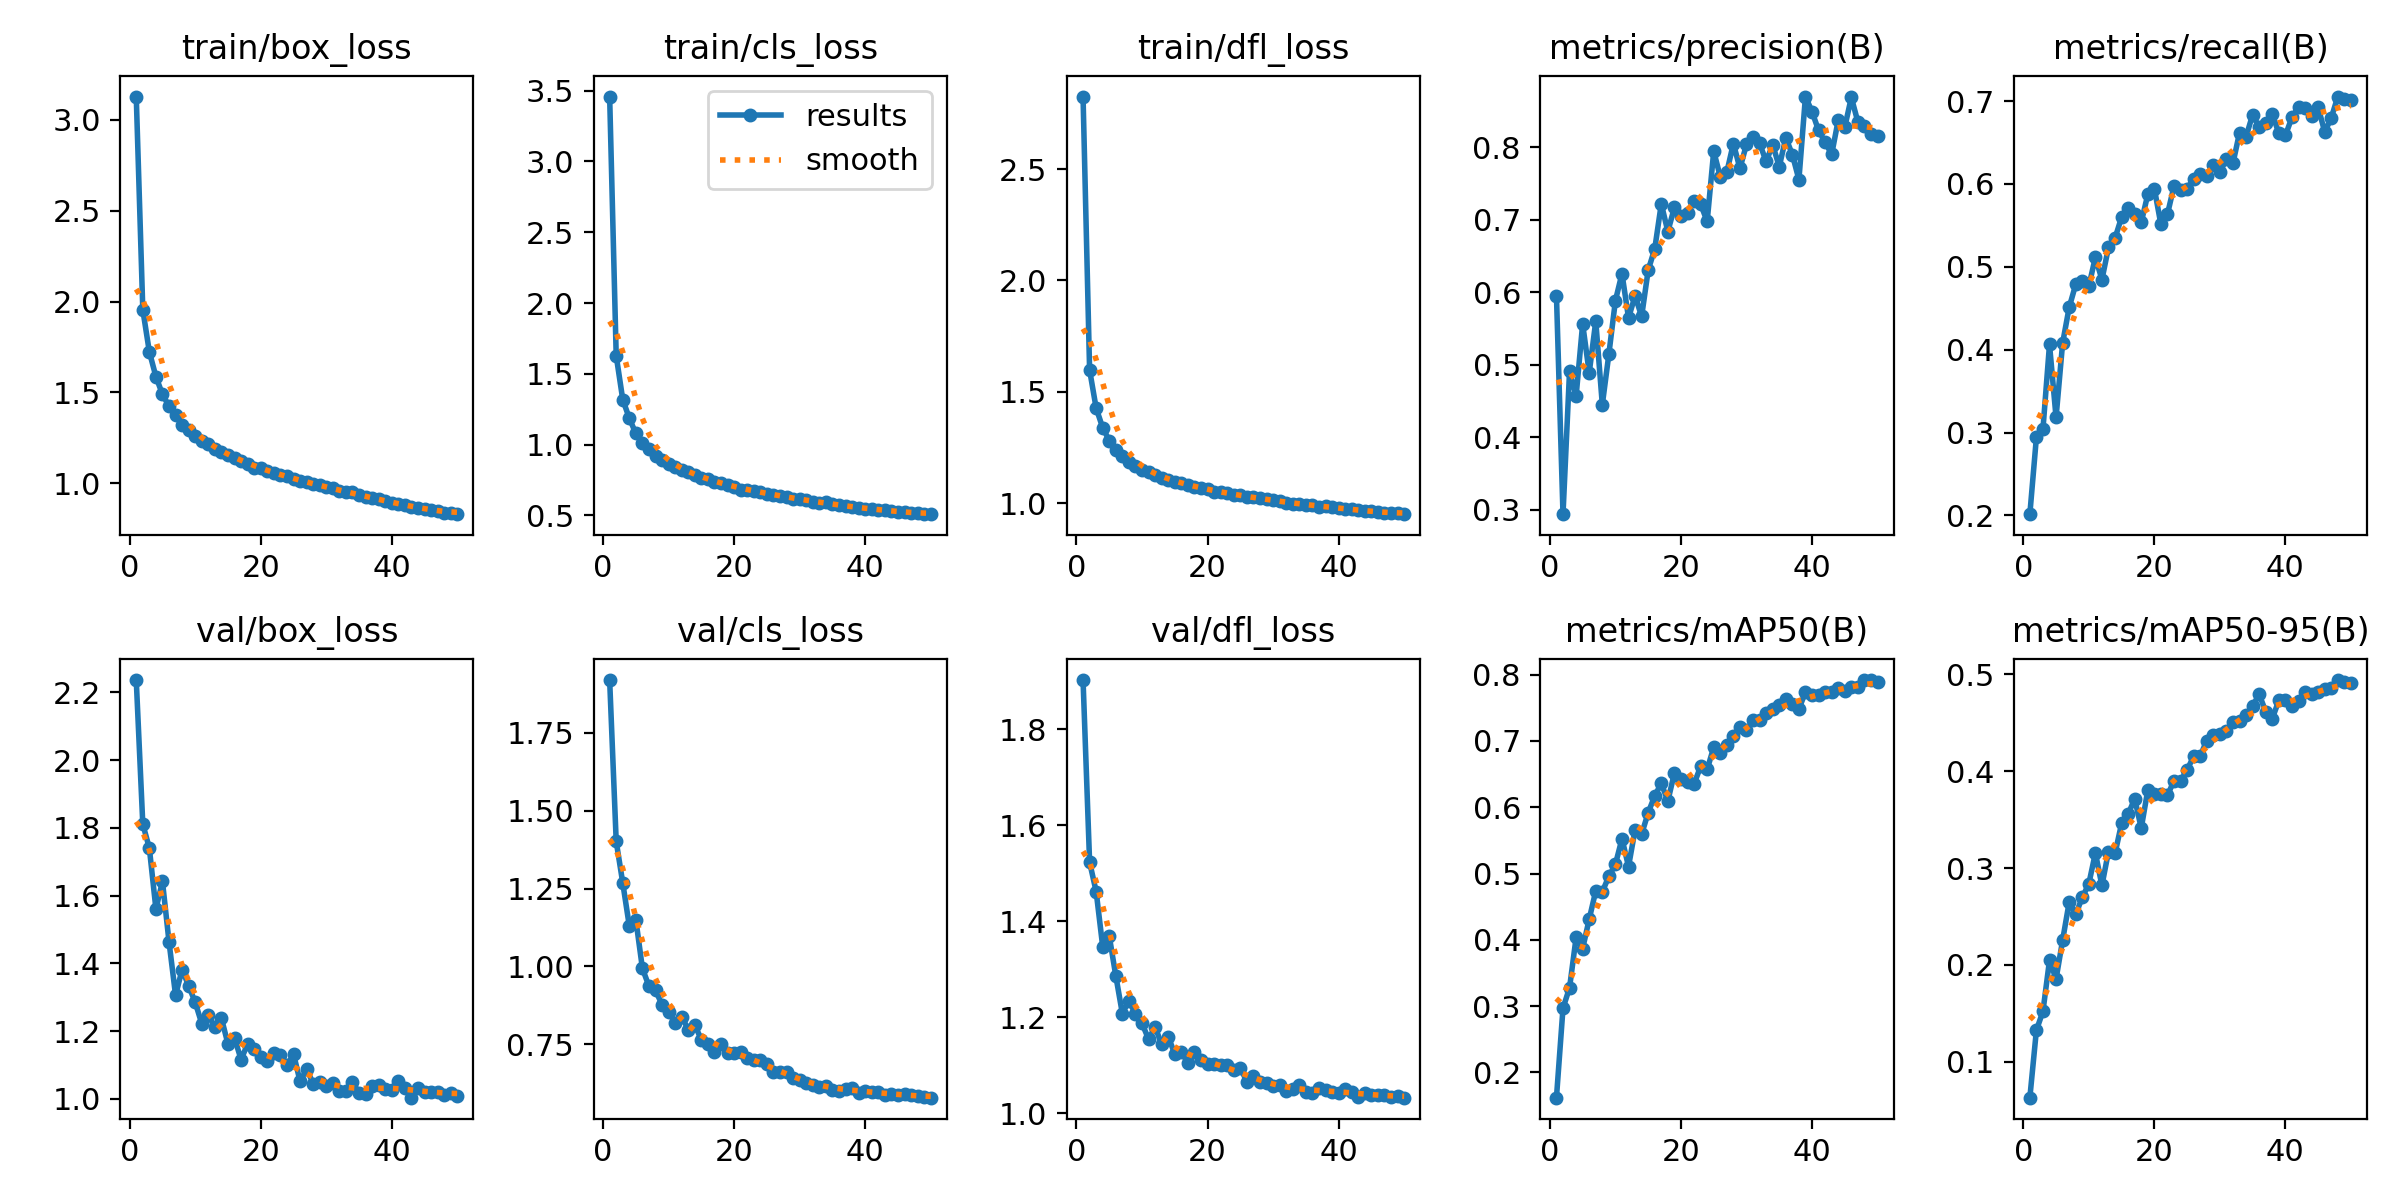

In [ ]:
# Hiển thị kết quả học (precision/recall/mAP curve)
display(DispImage(str(RUN_DIR/'results.png'), width=600))

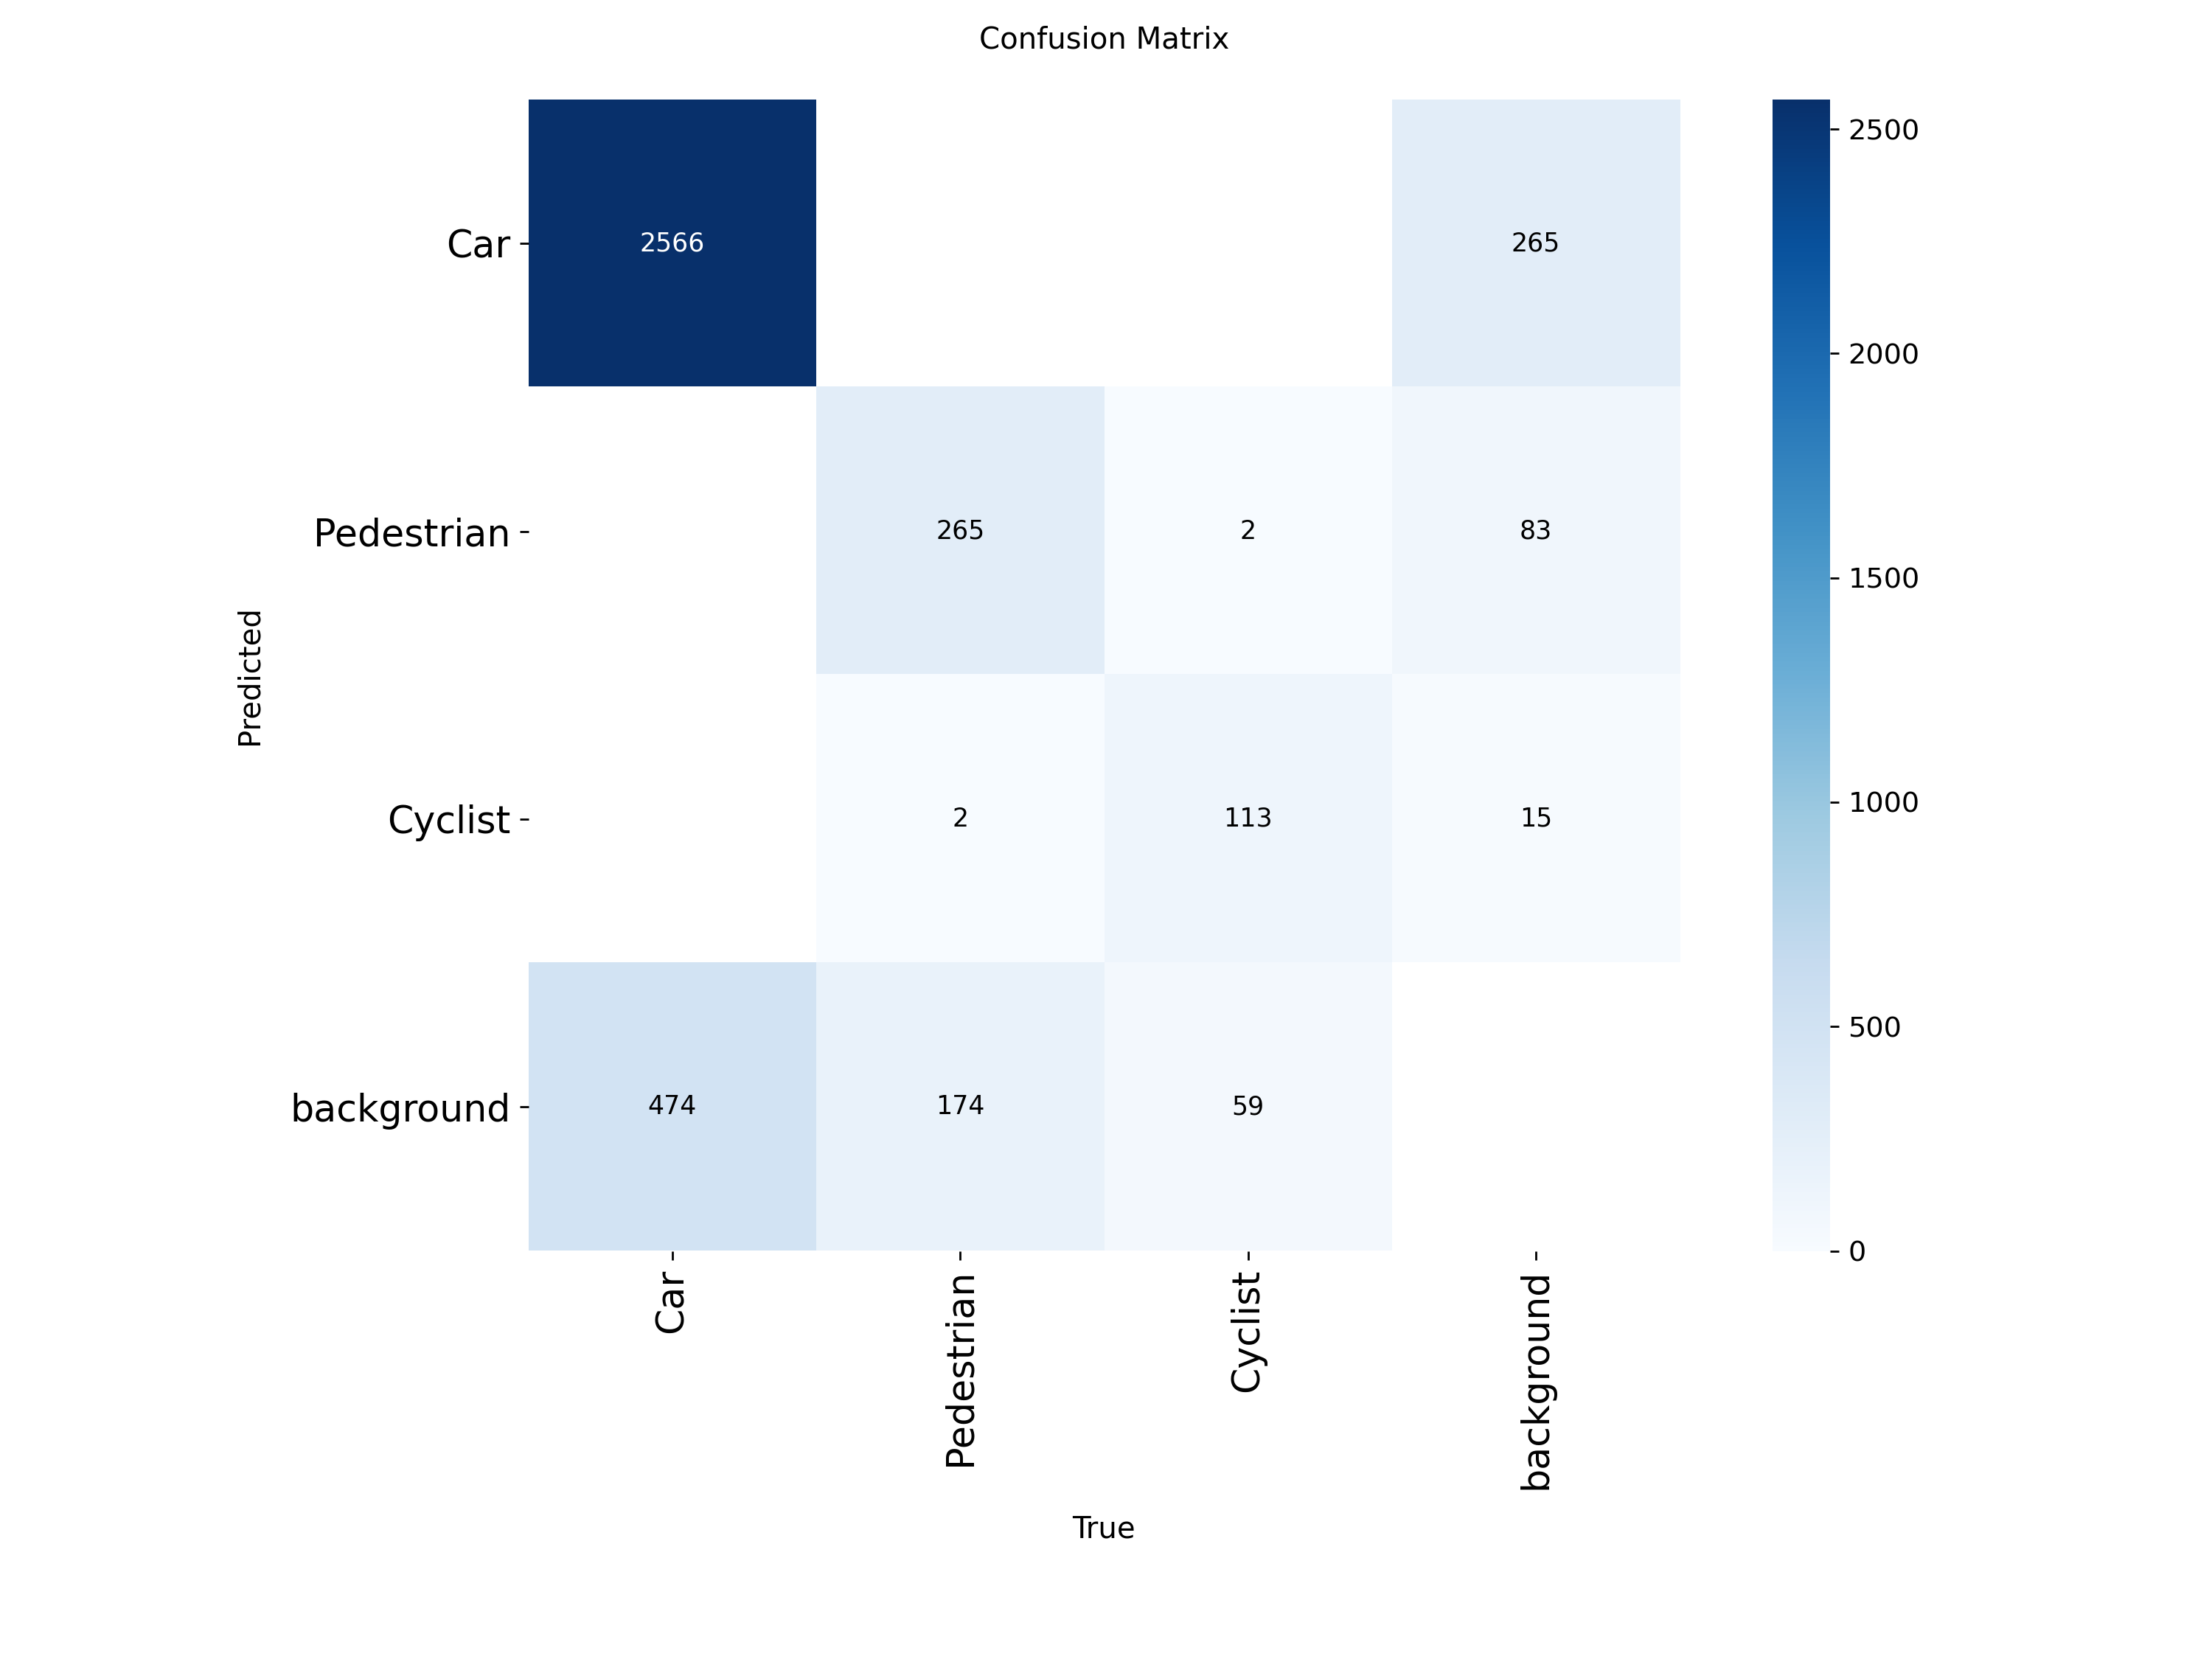

In [ ]:
# Hiển thị confusion matrix
display(DispImage(str(RUN_DIR/'confusion_matrix.png'), width=600))

# **đánh giá trên toàn bộ tập test**

In [ ]:
OUT_KITTI   = ROOT / 'kitti_preds_4chan_inpaint'

In [ ]:
# Load best.pt
best_pt = ROOT/'runs'/'yolov8_4chan_inpaint2'/'weights'/'best.pt'
model   = YOLO(str(best_pt))

OUT_KITTI.mkdir(exist_ok=True)
cls_map = {0:'Car',1:'Pedestrian',2:'Cyclist'}

for img_path in sorted(RGBD_TEST.glob('*_rgbd.png')):
    stem = img_path.stem.replace('_rgbd','')

      # --- chuẩn bị im4 như trước ---
    rgba_uint16 = cv2.imread(str(img_path), cv2.IMREAD_UNCHANGED)
    rgba = rgba_uint16.astype(np.float32)
    bgr   = rgba[..., :3]
    depth = rgba[..., 3] / 65535.0 * 255.0
    depth = depth[..., None]
    im4   = np.dstack((bgr, depth))

    # --- chạy predict với numpy array ---
    res = model.predict(source=im4, imgsz=640, device=0, verbose=False)[0]

    # --- trích kết quả và ghi thành file KITTI ---
    boxes   = res.boxes.xyxy.cpu().numpy()
    classes = res.boxes.cls.cpu().numpy().astype(int)
    confs   = res.boxes.conf.cpu().numpy()

    with open(OUT_KITTI/f'{stem}.txt','w') as f:
        for (x1,y1,x2,y2), c, p in zip(boxes, classes, confs):
            f.write(
                f"{cls_map[c]} 0 0 0 "
                f"{x1:.2f} {y1:.2f} {x2:.2f} {y2:.2f} "
                "0 0 0 0 0 0 0 "
                f"{p:.4f}\n"
            )
print(f"[✓] Đã xuất {len(list(OUT_KITTI.glob('*.txt')))} files tại {OUT_KITTI}")

[✓] Đã xuất 7518 files tại /content/drive/MyDrive/Khóa Luận/Data_Object/Code/Early_Fusion_RGBD_Yolov8/4chan/kitti_preds_4chan_inpaint


In [ ]:
# Nén cả thư mục dạng zip
shutil.make_archive('kitti_predictions_4chan_inpaint', 'zip', root_dir=str(OUT_KITTI))
print("Tạo file kitti_predictions_4chan_inpaint.zip thành công!")

Tạo file kitti_predictions_4chan_inpaint.zip thành công!


In [ ]:
from google.colab import runtime; runtime.unassign()